# Планирование открытия заведений общественного питания
Итак, инвесторы планируют открыть новое заведение общественного питания в Москве. На данный момент неизвестен ни формат, ни расположение, ни меню, ни ценовая политика. Требуется провести исследование рынка Москвы на предмет возможных интересных особенностей, которые помогут с будущим выбором. Для целей работы:
- ознакомимся с данными и выполним предобработку: проверим на возможные дубликаты и разберёмся с пропусками, где это возможно.
- проведем анализ данных:
    - изучим в какие категории заведений имеются в данных,
    - в каких районах располагаются
    - какое количество посадочных мест у заведений
    - какие есть сетевые и несетевые заведения
    - какие рейтинги у различных категорий и в различных районах
    - какой размер среднего чека у заведений в разных районах
    - как обстоят дела, в частности, с кофейнями
- сделаем выводы


In [1]:
import pandas as pd
import numpy as np
from Levenshtein import distance as lev
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import median
import plotly.express as px
from plotly import graph_objects as go
import folium
from folium import Map, Marker, Choropleth
from folium.plugins import MarkerCluster
import json

## Знакомство с данными
Выгрузим данные

In [2]:
data = pd.read_csv('C:\\Users\\Marat\\Documents\\Marat\\data_analyse\\projects\\planning_of_catering\\moscow_places.csv')
data.head()

name  category                              address  \
0                WoWфли      кафе           Москва, улица Дыбенко, 7/1   
1        Четыре комнаты  ресторан   Москва, улица Дыбенко, 36, корп. 1   
2                 Хазри      кафе       Москва, Клязьминская улица, 15   
3  Dormouse Coffee Shop   кофейня  Москва, улица Маршала Федоренко, 12   
4             Иль Марко  пиццерия      Москва, Правобережная улица, 1Б   

                          district  \
0  Северный административный округ   
1  Северный административный округ   
2  Северный административный округ   
3  Северный административный округ   
4  Северный административный округ   

                                               hours        lat        lng  \
0                             ежедневно, 10:00–22:00  55.878494  37.478860   
1                             ежедневно, 10:00–22:00  55.875801  37.484479   
2  пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...  55.889146  37.525901   
3                             ежедневно, 09:00–22:00  55.881608  37.488860   
4                             ежедневно, 10:00–22:00  55.881166  37.449357   

   rating          price                       avg_bill  middle_avg_bill  \
0     5.0            NaN                            NaN              NaN   
1     4.5  выше среднего       Средний счёт:1500–1600 ₽           1550.0   
2     4.6        средние         Средний счёт:от 1000 ₽           1000.0   
3     5.0            NaN  Цена чашки капучино:155–185 ₽              NaN   
4     5.0        средние         Средний счёт:400–600 ₽            500.0   

   middle_coffee_cup  chain  seats  
0                NaN      0    NaN  
1                NaN      0    4.0  
2                NaN      0   45.0  
3              170.0      0    NaN  
4                NaN      1  148.0

In [3]:
# Далее посмотрим подробнее информацию по датасету
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8406 non-null   object 
 1   category           8406 non-null   object 
 2   address            8406 non-null   object 
 3   district           8406 non-null   object 
 4   hours              7870 non-null   object 
 5   lat                8406 non-null   float64
 6   lng                8406 non-null   float64
 7   rating             8406 non-null   float64
 8   price              3315 non-null   object 
 9   avg_bill           3816 non-null   object 
 10  middle_avg_bill    3149 non-null   float64
 11  middle_coffee_cup  535 non-null    float64
 12  chain              8406 non-null   int64  
 13  seats              4795 non-null   float64
dtypes: float64(6), int64(1), object(7)
memory usage: 919.5+ KB


Итак, у нас имеется 8406 записей (соответственно речь идёт таком же количестве заведений общественного питания, однако стоит проверить на наличие дубликатов). Имеется 14 столбцов:
1) `name` - название кафе, ресторанов и т.д. Пропусков нет. Имеет смысл проверить на возможные неявные дубликаты.   
2) `category` - категория заведения (кафе, кофейня, ресторан, пиццерия и т.д.). Пропусков нет. Проверить на наличие неявных дубликатов.  
3) `address` - адрес. Пропусков нет. На всякий случай имеет смысл проверить, чтобы все адреса касались именно Москвы.  
4) `district` - район. Пропусков нет. Проверить на наличие неявных дубликатов.  
5) `hours` - часы и дни работы.  Есть пропуски - посмотреть, что с ними можно сделать.  
6) `lat` - широта. Пропусков нет.  
7) `lng` - долгота. Пропусков нет.  
8) `rating` - рейтинг. Пропусков нет. Их в принципе нет смысла трогать.  
9) `price` - уровень цен. Очень много пропусков.  
10) `avg_bill` - средняя стоимость заказа (категория в виде диапазона).  Также много пропусков.  
11) `middle_avg_bill` - число с оценкой среднего чека. Много пропусков.
11) `middle_coffee_cup` - число с оценкой чашки кофе.  Также много пропусков.  
12) `chain` - относится ли заведение к сети или нет. Пропусков нет  
13) `seats` - количество посадочных мест. Имеются пропуски.  

## Предобработка данных

In [4]:
# Проверим для начала дубликаты по всему датасету
data.duplicated().sum()

0

Т.е. на первый взгляд полных дубликатов нет. Далее посмотрим подробнее по столбцам.

### Название заведения

In [5]:
# посмотрим количество уникальных значений значения по столбцу 'name'
data['name'].nunique()

5614

Уникальных названий заведений в списке 5614, т.е. можно предположить, что приличная часть заведений являются частью сети или имеют схожие названия. Выведем список уникальных названий заведений с их количеством.

In [6]:
data['name'].value_counts().head(20)

name
Кафе                                   189
Шоколадница                            120
Домино'с Пицца                          76
Додо Пицца                              74
One Price Coffee                        71
Яндекс Лавка                            69
Cofix                                   65
Prime                                   50
Хинкальная                              44
Шаурма                                  43
КОФЕПОРТ                                42
Кулинарная лавка братьев Караваевых     39
Теремок                                 38
Чайхана                                 37
Ресторан                                34
CofeFest                                32
Буханка                                 32
Столовая                                28
Му-Му                                   27
Drive Café                              24
Name: count, dtype: int64

По данному списку можно сделать наблюдение, что у части заведений не указаны названия - вместо этого имеют универсальное обозначение (кафе, бистро, ресторан, столовая). Но всё равно остаётся риск, что могут повторяться заведения (особенно, если речь идёт о сетях), названия которых написаны разными способами (с различными разделителями или разным регистром). Попробуем их отработать (например: удалить те знаки, которые чаще всего в альтернативных написаниях могли быть пропущены, а некоторые заменим на пробелы. Также уберём лишние пробелы, если где-то такие могут быть

In [7]:
# для начала переведём все в нижний регистр
data['name'] = data['name'].apply(lambda x: x.lower())

# заменим символы-делители и прочие ("'", "/", ":", ";", "-" и т.д.) просто на пробелы или удалим совсем.

def symbols(name):
    # удалим символы
    new_name = 0   
    for symbol_1 in ["'", ":", ";", ",", "!", "#", "%", "№", "@", "="]:
        if new_name == 0:
            if symbol_1 in name:
                new_name = name.replace(symbol_1, "")
            else:
                new_name = name
        else:
            if symbol_1 in new_name:
                new_name = new_name.replace(symbol_1, "")
            else:
                new_name = new_name  
    # заменим символы на пробелы
    for symbol_2 in ["/", "-", "_", "+"]:
        if symbol_2 in new_name:
            new_name = new_name.replace(symbol_2, " ")
        else:
            new_name = new_name
    # уберём точки '.' (там, где за точкой буква - на пробел, в остальных случаях удаляем)
    while '.' in new_name:
        i = new_name.find('.')
        if i < len(new_name) - 1:
            if new_name[i+1] == '.' or new_name[i+1] == ' ':
                new_name = new_name[:i] + '' + new_name[i+1:]
            else:
                new_name = new_name[:i] + ' ' + new_name[i+1:]
        else:
            new_name = new_name.replace('.', '')
    # уберём лишние пробелы, если они есть
    new_name = ' '.join(new_name.split())
    return new_name

data['name'] = data['name'].apply(symbols)
# посмотрим, сколько уникальных названий осталось
data['name'].nunique()



5480

Уникальных названий осталось 5480 (т.е. отработано порядка 134 наименований).

In [8]:
# посмтотрим, сколько всего уникальных названий среди сетевых заведений
data[data['chain'] == 1]['name'].nunique()

742

При дальнейшей проверке стоит посмотреть, чтобы одни и те же названия (за исключением универсальных) не располагалась по одним тем же адресам.

In [9]:
data[['name', 'address']].duplicated().sum()

4

Есть 4 заведения с одним и тем же (или похожим в изначальном датасете) названием, которые располагаются по одному и тому же адресу. Посмотрим на них.

In [10]:
name_adress = (
    data.groupby(['name', 'address'], as_index=False)
    .agg({'category': 'count'})
    .rename(columns={'category': 'cnt_cafe'})
    .sort_values(by='cnt_cafe', ascending=False)
    .query('cnt_cafe > 1')
)
name_adress

name  \
7484            хлеб да выпечка   
1453                  more poke   
3042            в парке вкуснее   
6195  раковарня клешни и хвосты   

                                                address  cnt_cafe  
7484                        Москва, Ярцевская улица, 19         2  
1453            Москва, Волоколамское шоссе, 11, стр. 2         2  
3042  Москва, Северный административный округ, район...         2  
6195                         Москва, проспект Мира, 118         2

Действительно есть 4 кафе, которые попали в датасет дважды. Попробуем их убрать. Выведем полные данные в датасете по ним.

In [11]:
data.loc[(data['name'].isin(name_adress['name'])) & (data['address'].isin(name_adress['address']))]

name  category  \
599             в парке вкуснее      кафе   
600             в парке вкуснее   кофейня   
1430                  more poke  ресторан   
1511                  more poke  ресторан   
2211  раковарня клешни и хвосты  ресторан   
2420  раковарня клешни и хвосты   бар,паб   
3091            хлеб да выпечка  булочная   
3109            хлеб да выпечка      кафе   

                                                address  \
599   Москва, Северный административный округ, район...   
600   Москва, Северный административный округ, район...   
1430            Москва, Волоколамское шоссе, 11, стр. 2   
1511            Москва, Волоколамское шоссе, 11, стр. 2   
2211                         Москва, проспект Мира, 118   
2420                         Москва, проспект Мира, 118   
3091                        Москва, Ярцевская улица, 19   
3109                        Москва, Ярцевская улица, 19   

                                     district  \
599           Северный административный округ   
600           Северный административный округ   
1430          Северный административный округ   
1511          Северный административный округ   
2211  Северо-Восточный административный округ   
2420  Северо-Восточный административный округ   
3091          Западный административный округ   
3109          Западный административный округ   

                                                  hours        lat        lng  \
599                              ежедневно, 10:00–21:00  55.854571  37.487254   
600                              ежедневно, 10:00–21:00  55.851985  37.478492   
1430                             ежедневно, 09:00–21:00  55.806307  37.497566   
1511  пн-чт 09:00–18:00; пт,сб 09:00–21:00; вс 09:00...  55.806307  37.497566   
2211                             ежедневно, 12:00–00:00  55.810553  37.638161   
2420  пн-чт 12:00–00:00; пт,сб 12:00–01:00; вс 12:00...  55.810677  37.638379   
3091                             ежедневно, 09:00–22:00  55.738886  37.411648   
3109                                                NaN  55.738449  37.410937   

      rating price avg_bill  middle_avg_bill  middle_coffee_cup  chain  seats  
599      2.2   NaN      NaN              NaN                NaN      0    NaN  
600      2.2   NaN      NaN              NaN                NaN      1    NaN  
1430     4.2   NaN      NaN              NaN                NaN      0  188.0  
1511     4.2   NaN      NaN              NaN                NaN      1  188.0  
2211     4.4   NaN      NaN              NaN                NaN      0  150.0  
2420     4.4   NaN      NaN              NaN                NaN      1  150.0  
3091     4.1   NaN      NaN              NaN                NaN      1  276.0  
3109     4.1   NaN      NaN              NaN                NaN      0  276.0

Итак, есть 4 кафе, у которых задублировались данные. Данные по строкам практически полностью совпадают, за исключением столбца `категория`, `часы работы` и принадлежность к сети (в каких-то случаях стоит `1`, а в каких-то `0`). Вероятно, что все эти кафе являются всё-таки частью своих сетей, и в рамках сети должны иметь одинаковые категории (с часами работы сложнее - тут могут быть отличия). Посмотрим, как обстоят дела у этих заведений и по другим адресам.

In [12]:
data[data['name'].isin(name_adress['name'])].sort_values(by='name')

name  category  \
1430                  more poke  ресторан   
1511                  more poke  ресторан   
6088                  more poke  ресторан   
25              в парке вкуснее   кофейня   
599             в парке вкуснее      кафе   
600             в парке вкуснее   кофейня   
7473            в парке вкуснее   кофейня   
7474            в парке вкуснее   кофейня   
2211  раковарня клешни и хвосты  ресторан   
2420  раковарня клешни и хвосты   бар,паб   
7270  раковарня клешни и хвосты   бар,паб   
3091            хлеб да выпечка  булочная   
3109            хлеб да выпечка      кафе   
7937            хлеб да выпечка   кофейня   

                                                address  \
1430            Москва, Волоколамское шоссе, 11, стр. 2   
1511            Москва, Волоколамское шоссе, 11, стр. 2   
6088                     Москва, Духовской переулок, 19   
25                            Москва, парк Левобережный   
599   Москва, Северный административный округ, район...   
600   Москва, Северный административный округ, район...   
7473                     Москва, парк Борисовские пруды   
7474         Москва, парк имени 850-летия города Москвы   
2211                         Москва, проспект Мира, 118   
2420                         Москва, проспект Мира, 118   
7270                    Москва, Братиславская улица, 12   
3091                        Москва, Ярцевская улица, 19   
3109                        Москва, Ярцевская улица, 19   
7937                       Москва, Каширское шоссе, 61Г   

                                     district  \
1430          Северный административный округ   
1511          Северный административный округ   
6088             Южный административный округ   
25            Северный административный округ   
599           Северный административный округ   
600           Северный административный округ   
7473             Южный административный округ   
7474     Юго-Восточный административный округ   
2211  Северо-Восточный административный округ   
2420  Северо-Восточный административный округ   
7270     Юго-Восточный административный округ   
3091          Западный административный округ   
3109          Западный административный округ   
7937             Южный административный округ   

                                                  hours        lat        lng  \
1430                             ежедневно, 09:00–21:00  55.806307  37.497566   
1511  пн-чт 09:00–18:00; пт,сб 09:00–21:00; вс 09:00...  55.806307  37.497566   
6088                             ежедневно, 10:00–22:00  55.704177  37.612889   
25                               ежедневно, 10:00–21:00  55.878453  37.460028   
599                              ежедневно, 10:00–21:00  55.854571  37.487254   
600                              ежедневно, 10:00–21:00  55.851985  37.478492   
7473                             ежедневно, 10:00–21:00  55.633198  37.706064   
7474                             ежедневно, 10:00–21:00  55.642314  37.728390   
2211                             ежедневно, 12:00–00:00  55.810553  37.638161   
2420  пн-чт 12:00–00:00; пт,сб 12:00–01:00; вс 12:00...  55.810677  37.638379   
7270  пн-чт 12:00–00:00; пт,сб 12:00–01:00; вс 12:00...  55.659744  37.752984   
3091                             ежедневно, 09:00–22:00  55.738886  37.411648   
3109                                                NaN  55.738449  37.410937   
7937                             ежедневно, 09:00–22:00  55.621379  37.714108   

      rating    price                    avg_bill  middle_avg_bill  \
1430     4.2      NaN                         NaN              NaN   
1511     4.2      NaN                         NaN              NaN   
6088     4.4      NaN                         NaN              NaN   
25       4.3      NaN                         NaN              NaN   
599      2.2      NaN                         NaN              NaN   
600      2.2      NaN                         NaN              NaN   
7473     4.3      NaN  

Т.е. сделать также наблюдение, что практически у всех найденных дубликатов ошибочно указана категория. Перед удалением дубликатов Мы можем исправить столбцы `категория` и принадлежность к сети.

In [13]:
# сначала составим список указанных кафе с категориями и их количеством отсортировав по наименованию
name_dubl = (
    data[data['name'].isin(name_adress['name'])]
    .groupby(['name', 'category'], as_index=False)
    .agg({'address': 'count'})
    .rename(columns={'address': 'cnt_category'})
    .sort_values(by= ['name', 'cnt_category'], ascending=False)    
)
name_dubl


name  category  cnt_category
5            хлеб да выпечка  булочная             1
6            хлеб да выпечка      кафе             1
7            хлеб да выпечка   кофейня             1
3  раковарня клешни и хвосты   бар,паб             2
4  раковарня клешни и хвосты  ресторан             1
2            в парке вкуснее   кофейня             4
1            в парке вкуснее      кафе             1
0                  more poke  ресторан             3

In [14]:
# отберём только те категории к указанным заведениям, которые встречаются чаще всего 
# (в случае с заведением "хлеб да выпечка" очевидно, что речь идёт о булочной - идёт первой в списке - поэтому оставим эту категорию)
name_dubl = name_dubl.drop_duplicates(subset=['name'], keep='first').reset_index(drop=True)
name_dubl

# функция для сбора словаря (в нашем случае заведение - категория)
def make_dict(df, p1, p2):
    dictionary = {}
    for i in range(0, len(df)):
        dictionary[df[p1][i]] = df[p2][i]
    return dictionary

name_dubl_dict = make_dict(name_dubl, 'name', 'category')
name_dubl_dict


{'хлеб да выпечка': 'булочная',
 'раковарня клешни и хвосты': 'бар,паб',
 'в парке вкуснее': 'кофейня',
 'more poke': 'ресторан'}

In [15]:
#  далее в найденных дубликатах заменим некорректные категории, а также сразу исправим столбец с принадлежностью к сети.
for name in name_dubl['name']:
    data.loc[(data['name'] == name), 'category'] = name_dubl_dict[name]

data.loc[(data['name'].isin(name_dubl['name'])) & (data['chain'] == 0), 'chain'] = 1

# теперь удалим дубликаты, оставив только первые записи (как наиболее полные)
new_data = data.drop_duplicates(subset=['name', 'address'], keep='first').copy()
print('удалённые строки:', len(data) - len(new_data))
print('проверяем количество названий заведений:', new_data['name'].nunique())

удалённые строки: 4
проверяем количество названий заведений: 5480


Итак, Мы удалили 4 строки с повторяющимися данными. А количество названий заведений остаётся 5480.

### Категории заведений
Посмотрим, какие есть категории заведений и нет ли проблем в них.

In [16]:
new_data['category'].unique()

array(['кафе', 'ресторан', 'кофейня', 'пиццерия', 'бар,паб',
       'быстрое питание', 'булочная', 'столовая'], dtype=object)

Итак, у нас есть всего 8 категорий. Неявных дубликатов среди них нет.   
Как мы уже видели в предобработке по названиям у сетевых заведений бывают указаны различные категории, хотя, по идее должны относится к одному и тому же типу. Посмотрим, как обстоят дела в остальных сетях. 

In [17]:
# сгруппируем по названиям собрав данные по количесту самих заведений (которые являются сетями) и сколько на них приходится категорий
catering_chain = (
    new_data.query('chain == 1')
    .groupby('name', as_index=False)
    .agg({'category': 'nunique', 'address': 'count'})
    .rename(columns={'category': 'cnt_cat', 'address': 'quantity'})
    .sort_values(by= ['cnt_cat', 'quantity'], ascending=False) 
)
print('количество наименований заведений, которые отмечены, как сети и которые имеют несколько категорий', len(catering_chain[catering_chain['cnt_cat'] > 1]))
print('общее количество сетевых ресторанов', catering_chain['quantity'].sum())
catering_chain.head(20)

количество наименований заведений, которые отмечены, как сети и которые имеют несколько категорий 341
общее количество сетевых ресторанов 3205


name  cnt_cat  quantity
476             му му        7        27
662        хинкальная        5        44
590            скалка        4        20
653            халяль        4        10
314  грузинская кухня        4         8
511        пельменная        4         4
681           чайхана        3        37
267           буханка        3        32
231          андерсон        3        22
412   крошка картошка        3        22
87      french bakery        3        20
212    wild bean cafe        3        16
381         кафетерий        3        15
378          кафе бар        3        14
310            грабли        3         8
432     лепим и варим        3         8
696           чайхона        3         8
285      вкус востока        3         6
340            дружба        3         6
402      кофе с собой        3         6

Поскольку в отношении различных заведений ситуация с категориями может сильно разниться и нельзя однозначно сказать, в каких случаях у заведений сети - это действительно другой формат, а в каких ошибка (например, некорректно указал пользователь), то постараемся обработать только те заведения , где на одну конкретную категорию приходится наибольшая доля по сравнению со всей остальной сетью (возьмём больше 65%)

In [18]:
# собираем данные - название, катеория и количество заведений по категориям.
catering_category = (
    new_data.query('chain == 1')
    .groupby(['name', 'category'], as_index=False)
    .agg({'address': 'count'})
    .rename(columns={'address': 'cnt_category'})
    .sort_values(by= ['name', 'cnt_category'], ascending=False) 
)

# добавляем долю заведений по каждой из категоий в рамках сети
def share_category(row):
    share = row['cnt_category'] / catering_category[catering_category['name'] == row['name']]['cnt_category'].sum()
    return share
catering_category['share'] = catering_category.apply(share_category, axis=1)

# отбираем заведения у которых на одну из категорий приходится более 65% заведений, но есть заведения и с другими категориями (принимаем за ошибки).
catering_main_category = catering_category.query('0.65 < share < 1').reset_index(drop=True)

# снова собираем словарь
cafe_category_dict = make_dict(catering_main_category, 'name', 'category')
cafe_category_dict

# поменяем категории на корректные у заведений сетей, на которые приходятся категории с меньшей долей
for name in catering_main_category['name']:
    new_data.loc[(new_data['name'] == name), 'category'] = cafe_category_dict[name]
    
print('количество сетей, у заведений которых были исправлены категории', catering_main_category['name'].count())
print('количество заведений, у которых были исправлены категории', catering_main_category['cnt_category'].sum())

количество сетей, у заведений которых были исправлены категории 110
количество заведений, у которых были исправлены категории 768


Итого: Мы у 768 заведений (которые относятся к 110 сетевым компаниям) заменили категории на те, что к ним относятся чаще всего. Остальные 2437 заведений (231 сеть) трогать не стали, т.к. в их случае нет однозначного уверенного перекоса в одну из категорий.

### Адреса
Далее посмотрим, чтобы все адреса касались только Москвы.

In [19]:
not_moscou  = []
for elem in data['address']:
    if 'Москва' not in elem:
        not_moscou.append(elem)
len(not_moscou)

0

Отлично! Все адреса указаны как московские (по крайней мере по данным датасета). 

### Районы
Далее посмотрим районы (чтобы также не было неявных дубликатов) 

In [20]:
new_data['district'].unique()

array(['Северный административный округ',
       'Северо-Восточный административный округ',
       'Северо-Западный административный округ',
       'Западный административный округ',
       'Центральный административный округ',
       'Восточный административный округ',
       'Юго-Восточный административный округ',
       'Южный административный округ',
       'Юго-Западный административный округ'], dtype=object)

Неявных дубликатов не обнаружено.

### Время работы
Далее посмотрим ситуацию со столбцом `hours` (время работы). Посмотрим, можно ли что-то сделать с пропусками. Для начала посмотрим на количество пропусков и какую долю в общем количестве заведений они занимают.

In [21]:
print('пропуски -', new_data['hours'].isna().sum())
print('общее количество заведений -', len(new_data))
print('доля пропусков -', round(new_data['hours'].isna().sum() / len(new_data), 3))

пропуски - 535
общее количество заведений - 8402
доля пропусков - 0.064


Всего пропусков 536, что составляет примерно 6,4%, что не очень много. 

In [22]:
print('количество вариантов времени работы:', new_data['hours'].nunique())
new_data['hours'].unique()

количество вариантов времени работы: 1306


array(['ежедневно, 10:00–22:00',
       'пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00–02:00',
       'ежедневно, 09:00–22:00', ...,
       'пн-пт 08:30–21:30; сб,вс 09:00–21:30',
       'пн-чт 13:00–22:00; пт,сб 13:00–22:30; вс 13:00–22:00',
       'пн-сб 10:30–21:30'], dtype=object)

У нас имеется 1308 вариантов времени работы. В данном случае найти какие более уникальные для всех заведений варианты времени работы довольно сложно - всё-таки каждое заведение работает по-своему.
Теоретически можно было бы часть пропусков снова заполнить, ориентируясь на наиболее часто встречающиеся значения в рамках сети, но даже у одной сети у разных заведений (тем более в разных районах) может быть разное время работы. Поэтому в данном случае пропуске заменим просто на слово "неизвестно"

In [23]:
new_data['hours'] = new_data['hours'].fillna('неизвестно')
new_data['hours'].isna().sum()

0

### Координаты местонахождения заведения
Пропусков в них нет, но могут быть дубликаты - проверим их.

In [24]:
new_data[['lat', 'lng']].duplicated().sum()

33

Итак, у нас есть случаи, когда по одним и тем же координатам значится несколько заведений. Возможно, что действительно в одном доме просто располагается несколько кафе. Посмотрим, много ли таких заведений.

In [25]:
# сгруппируем по координатам и посчитаем количество заведений, которые располагаются по этим координатам.
coordinates_neighbors = new_data.groupby(['lat', 'lng'], as_index=False).agg({'name': 'count'}).rename(columns={'name': 'name_cnt'})
coordinates_neighbors = coordinates_neighbors.query('name_cnt > 1')
coordinates_neighbors['name_cnt'].sum()

64

64 заведения, которые "делят" одно здание с другими представителями общепита (т.е. без дубликатов). Выведем для примера часть таких строк из датасета.

In [26]:
neighbors = new_data.loc[(new_data['lat'].isin(coordinates_neighbors['lat'])) & (new_data['lng']\
                                                                       .isin(coordinates_neighbors['lng']))]\
.sort_values(by=['lat', 'lng'])

display(neighbors.head(10))


name         category  \
7638         кофешефф         ресторан   
7640  крошка картошка  быстрое питание   
7781              ёрш         пиццерия   
7787           тануки         ресторан   
7660        100лоффка         столовая   
7767      за обе щёки             кафе   
6598          узбечка         столовая   
6809      кафе восток             кафе   
7362       хинкальная             кафе   
7407    старый дворик             кафе   

                                     address  \
7638      Москва, Новоясеневский проспект, 7   
7640      Москва, Новоясеневский проспект, 7   
7781      Москва, Липецкая улица, 2, корп. 8   
7787      Москва, Липецкая улица, 2, корп. 8   
7660       Москва, Варшавское шоссе, вл132/2   
7767       Москва, Варшавское шоссе, вл132/2   
6598     Москва, улица Академика Волгина, 2А   
6809     Москва, улица Академика Волгина, 2А   
7362  Москва, улица Нижние Поля, 19Б, стр. 1   
7407  Москва, улица Нижние Поля, 19Б, стр. 1   

                                  district                   hours        lat  \
7638   Юго-Западный административный округ  ежедневно, 08:30–21:00  55.607489   
7640   Юго-Западный административный округ  ежедневно, 10:00–22:00  55.607489   
7781          Южный административный округ  ежедневно, 11:30–05:00  55.608307   
7787          Южный административный округ  ежедневно, 10:00–05:00  55.608307   
7660          Южный административный округ       пн-пт 09:00–17:30  55.620316   
7767          Южный административный округ  ежедневно, 09:00–21:00  55.620316   
6598   Юго-Западный административный округ  ежедневно, 08:00–23:00  55.655107   
6809   Юго-Западный административный округ              неизвестно  55.655107   
7362  Юго-Восточный административный округ  ежедневно, 10:00–00:00  55.658424   
7407  Юго-Восточный административный округ  ежедневно, 10:00–00:00  55.658424   

            lng  rating          price                  avg_bill  \
7638  37.532367     4.3            NaN                       NaN   
7640  37.532367     4.1            NaN                       NaN   
7781  37.664941     4.4  выше среднего  Средний счёт:1000–1500 ₽   
7787  37.664941     4.3  выше среднего  Средний счёт:1000–1500 ₽   
7660  37.608922     4.4         низкие    Средний счёт:100–270 ₽   
7767  37.608922     3.6            NaN                       NaN   
6598  37.521641     4.6            NaN                       NaN   
6809  37.521641     2.9            NaN                       NaN   
7362  37.737291     4.3        средние     Средний счёт:от 300 ₽   
7407  37.737291     4.1        средние     Средний счёт:от 300 ₽   

      middle_avg_bill  middle_coffee_cup  chain  seats  
7638              NaN                NaN      0   60.0  
7640              NaN                NaN      1   60.0  
7781           1250.0                NaN      1  120.0  
7787           1250.0                NaN      1  120.0  
7660            185.0                NaN      0    NaN  
7767              NaN                NaN      1    NaN  
6598              NaN                NaN      1   49.0  
6809              NaN                NaN      0   49.0  
7362            300.0                NaN      1   45.0  
7407            300.0                NaN      1   45.0

In [27]:
# посмотрим, сколько есть уникальных названий заведений
neighbors['name'].value_counts()

name
хинкальная                        2
кофешефф                          1
сикварули                         1
пельменная вареничная             1
пловная чебуречная                1
                                 ..
prime                             1
белочка                           1
любовь пирогова                   1
кулинарная школа ginza project    1
карелия                           1
Name: count, Length: 63, dtype: int64

"хинкальная" появляется дважды - проверим её на всякий случай

In [28]:
neighbors[neighbors['name'] == 'хинкальная']

name category                                 address  \
7362  хинкальная     кафе  Москва, улица Нижние Поля, 19Б, стр. 1   
3001  хинкальная     кафе     Москва, Краснобогатырская улица, 79   

                                  district                   hours        lat  \
7362  Юго-Восточный административный округ  ежедневно, 10:00–00:00  55.658424   
3001      Восточный административный округ  ежедневно, 09:00–00:00  55.805361   

            lng  rating    price               avg_bill  middle_avg_bill  \
7362  37.737291     4.3  средние  Средний счёт:от 300 ₽            300.0   
3001  37.708967     4.1      NaN                    NaN              NaN   

      middle_coffee_cup  chain  seats  
7362                NaN      1   45.0  
3001                NaN      1    NaN

Это два разных заведения с разными адресами, т.е. всё в порядке.  
В остальных 63 заведениях, которые между собой соседствуют, могут закрасться дубликаты. Проверим их

In [29]:
# попробуем пройтись по списку названий заведений, которые оказались по одним координатам, и проверить их между собой по расстоянию Левенштейна
# те,у которых это расстояние по отношению к общему размеру названия окажется меньше 0,35, положим в отдельный список

suspicious_names = []
for lat, lng in zip(coordinates_neighbors['lat'], coordinates_neighbors['lng']):
    names_same_address = neighbors.loc[(neighbors['lat'] == lat) & (neighbors['lng'] == lng)]['name'].unique()
    for i in range(0, len(names_same_address)):
        temporary_names = []
        if i < len(names_same_address)-1:
            for j in range(i+1, len(names_same_address)):
                lev_distance = lev(names_same_address[i], names_same_address[j])
                if lev_distance / len(names_same_address[i]) <=0.5:
                    temporary_names.append(names_same_address[j])
            if len(temporary_names) != 0:
                temporary_names.append(names_same_address[i])
            suspicious_names += temporary_names[:]
suspicious_names

['чайхана döner', 'чайхана doner кафе']

К числу "странных" названий заведений, которые находятся по одному адресу, можно точно отнести "чайхана döner" и 'чайхана doner кафе'. Выведем эти строки сразу в общем датасете.

In [30]:
new_data[new_data['name'].isin(suspicious_names)]

name category                                    address  \
2697  чайхана doner кафе     кафе  Москва, Измайловский проспект, 61, стр. 2   
2841       чайхана döner     кафе        Москва, Измайловский проспект, 61с2   

                              district                     hours       lat  \
2697  Восточный административный округ  ежедневно, круглосуточно  55.78861   
2841  Восточный административный округ  ежедневно, круглосуточно  55.78861   

           lng  rating price avg_bill  middle_avg_bill  middle_coffee_cup  \
2697  37.78397     4.0   NaN      NaN              NaN                NaN   
2841  37.78397     4.0   NaN      NaN              NaN                NaN   

      chain  seats  
2697      0   15.0  
2841      0    NaN

Однозначный дубликат. Удалим его

In [31]:
# заменим название, чтобы везде было "чайхана doner кафе"
new_data['name'] = new_data['name'].replace('чайхана döner', 'чайхана doner кафе')
# оставим только первую строчку из этих дубликатов.
new_data = new_data.drop_duplicates(subset=['name', 'lat', 'lng'], keep='first')
new_data['name'].count()

8401

Таким образом отсеялся ещё один дубликат. Остаётся 8401 заведение.

### Принадлежность к сети
Принадлежность к сети стоит перепроверить немного вне очереди, т.к. внутри сети могут быть какие-то закономерности, и, если в этом столбце есть ошибки или пропуски, то лучше их исправить.  
Пропусков не наблюдалось, но проверим, чтобы у каждого заведения, которое входит в сеть, всегда стояла в столбце `chain` единица.

In [32]:
# сначала составим список заведений, которые отмечены, как сети:
chains = new_data[new_data['chain'] == 1]['name'].unique()

# сгруппируем по названию (только по тем названиям, у которых хотя бы раз была отметка о сети) 
# выведем количество заведений всего, 
# количество заведений, у которых отмечена принадлежность к сети 
# и долю вторых в числе первых.
catering_chain = (
    new_data.query('name in @chains').pivot_table(index='name', values='chain', aggfunc=['count', 'sum', 'mean'])
    .reset_index()
)
catering_chain.columns = ['name', 'total_count', 'if_chain_cnt', 'share']
# проверим сколько имеется названий заведений, у которых хотя бы одно место отмечено, как часть сети, но у каких-то в то же время стоит ноль
print('количество предполагаемых сетей, где отдельные заведения почему-то не отмечены как сети:', catering_chain.query('share < 1')['name'].count())
print('количество таких заведений:',
      catering_chain.query('share < 1')['total_count'].sum() - catering_chain.query('share < 1')['if_chain_cnt'].sum()
     )

количество предполагаемых сетей, где отдельные заведения почему-то не отмечены как сети: 43
количество таких заведений: 56


Итак, имеется 56 заведений, которые не отмечены, как сети, хотя в датасете имеются заведения с такими же названиями, которые входят в сеть. Попробуем как-нибудь разобраться с этим.  
Посмотрим, как распределяются доли заведений, отмеченных как сеть по отношению к общему количеству заведений с таким же названием (там, где есть хотя бы одно заведение, неотмеченное как сеть).

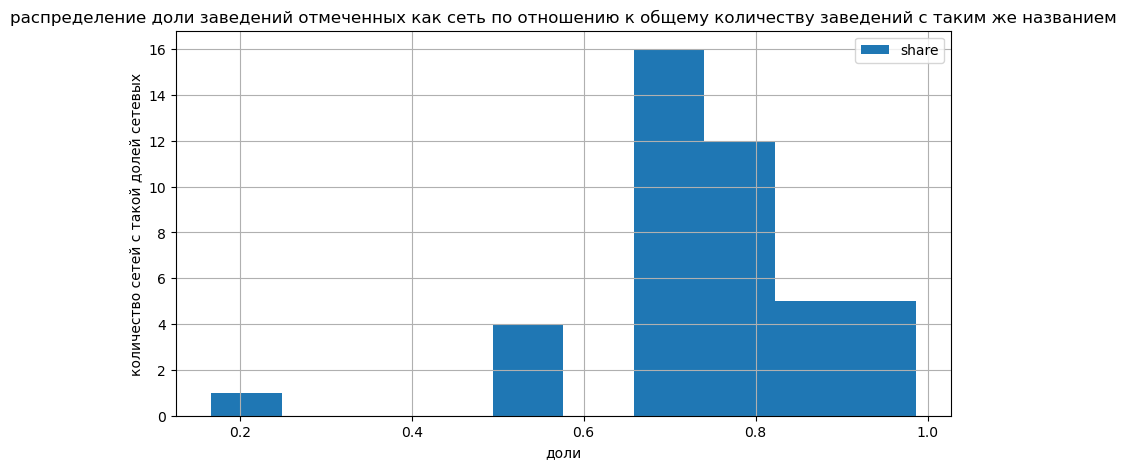

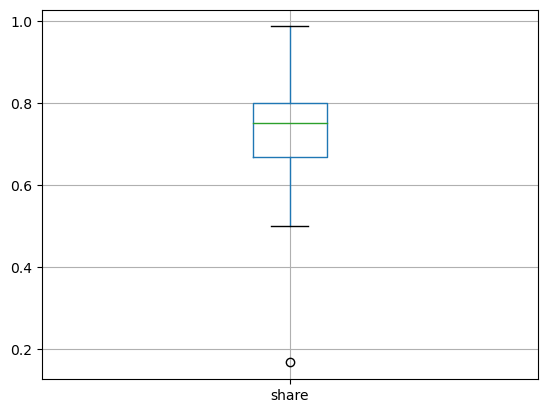

In [33]:
# plt.figure(figsize=(15, 10))

catering_chain.query('share < 1').plot(kind='hist', y = 'share', bins=10, grid=True, figsize=(10, 5))

plt.title('распределение доли заведений отмеченных как сеть по отношению к общему количеству заведений с таким же названием')
plt.xlabel('доли')
plt.ylabel('количество сетей с такой долей сетевых')

plt.show()

catering_chain.query('share < 1').boxplot(column='share')
plt.show()



На графиках видно, что у большей части названий заведений, где встречаются одновременно две отметки по поводу сети, доля заведений с отметкой "сеть" составляет более 50%. Т.е. можно предположить, что и в остальных случаях также должна была быть отметка "сеть". Поэтому в этих остальных случаях также проставим отметку о принадлежности к сети.

In [34]:
for name in catering_chain.query('0.5 < share < 1')['name'].unique():
    new_data.loc[(new_data['name'] == name), 'chain'] = 1
    
# ещё раз сгруппируем тем же образом названия, где есть отметки о сетях   
catering_chain = (
    new_data.query('name in @chains').pivot_table(index='name', values='chain', aggfunc=['count', 'sum', 'mean'])
    .reset_index()
)
catering_chain.columns = ['name', 'total_count', 'if_chain_cnt', 'share']
# ещё раз проверим сколько имеется названий заведений, у которых хотя бы одно место отмечено как часть сети, но у каких-то в то же время стоит ноль
print('количество оставшихся заведений, чьи наименования присутствют в нескольких записях, в том числе в сетях:',
      catering_chain.query('share < 1')['total_count'].sum() - catering_chain.query('share < 1')['if_chain_cnt'].sum()
     )

количество оставшихся заведений, чьи наименования присутствют в нескольких записях, в том числе в сетях: 15


Таким образом было откорректировано 41 заведение.

### Категория цен
Здесь имелись пропуски. Посмотрим, что с этим можно сделать.

In [35]:
# ещё раз посмотрим на количество пропусков
new_data['price'].isna().sum()

5086

Очень много пропусков. Теоретически можно было бы обработать по категории заведения, но при таком большом количестве пропусков есть риск сильно промахнуться. Для начала имеет смысл попробовать обработать часть пропусков по сетям, т.к. в рамках сети скорее всего уровень одинаковый. Проверим.

In [36]:
# сначала проверим, есть ли у сетей в принципе пропуски в столбце с категорией цены
new_data[new_data['chain'] == 1]['price'].isna().sum()

2095

На сети приходится 2095 пропусков в столбце категория цены. Посмотрим, что можно сделать

In [37]:
# для удобства доавим численное обозначение категории цены
# для начала сделаем словарь
# посмотрим, какие есть категории
new_data['price'].unique()

array([nan, 'выше среднего', 'средние', 'высокие', 'низкие'], dtype=object)

In [38]:
# словарь
price_category = {'низкие': 1, 'средние': 2, 'высокие': 3, 'выше среднего': 4}
# добавим столбец со численным обозначением ценовой категории
new_data['price_N'] = new_data.apply(lambda x: price_category.get(x['price']), axis=1)
new_data.head()

name  category                              address  \
0                wowфли      кафе           Москва, улица Дыбенко, 7/1   
1        четыре комнаты  ресторан   Москва, улица Дыбенко, 36, корп. 1   
2                 хазри      кафе       Москва, Клязьминская улица, 15   
3  dormouse coffee shop   кофейня  Москва, улица Маршала Федоренко, 12   
4             иль марко  пиццерия      Москва, Правобережная улица, 1Б   

                          district  \
0  Северный административный округ   
1  Северный административный округ   
2  Северный административный округ   
3  Северный административный округ   
4  Северный административный округ   

                                               hours        lat        lng  \
0                             ежедневно, 10:00–22:00  55.878494  37.478860   
1                             ежедневно, 10:00–22:00  55.875801  37.484479   
2  пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...  55.889146  37.525901   
3                             ежедневно, 09:00–22:00  55.881608  37.488860   
4                             ежедневно, 10:00–22:00  55.881166  37.449357   

   rating          price                       avg_bill  middle_avg_bill  \
0     5.0            NaN                            NaN              NaN   
1     4.5  выше среднего       Средний счёт:1500–1600 ₽           1550.0   
2     4.6        средние         Средний счёт:от 1000 ₽           1000.0   
3     5.0            NaN  Цена чашки капучино:155–185 ₽              NaN   
4     5.0        средние         Средний счёт:400–600 ₽            500.0   

   middle_coffee_cup  chain  seats  price_N  
0                NaN      0    NaN      NaN  
1                NaN      0    4.0      4.0  
2                NaN      0   45.0      2.0  
3              170.0      0    NaN      NaN  
4                NaN      1  148.0      2.0

In [39]:
# сгруппируем по наименованию сети и выведем для каждой количество категорий цен (выберем строки, где нет пропусков)
# также добавим туда и количество заведений в сети
name_chain_prices = (
    new_data.loc[(new_data['chain'] == 1) & (~new_data['price_N'].isna())]
    .groupby(['name'], as_index=False)
    .agg({'price_N': 'nunique', 'address': 'count'})
    .rename(columns={'address': 'cnt'})
)
name_chain_prices.head()

name  price_N  cnt
0                       18 грамм        1    2
1                    7 сэндвичей        1    3
2            abc coffee roasters        1    1
3                     air coffee        1    1
4  americano black coffee & food        2    2

In [40]:
# сравним эти наименования заведений с теми сетевыми, у которых есть пропуски 
chains_with_nan = new_data.loc[(new_data['chain'] == 1) & (new_data['price_N'].isna())]['name'].unique()
# отберём только те сети, у которых имеется более 10 заведений с заполненной категорией и где есть пропуски.
changing_chains = name_chain_prices[(name_chain_prices['name'].isin(chains_with_nan)) & (name_chain_prices['cnt'] > 10)]['name']

# посмотрим сколько пропусков можно заполнить
print(new_data.loc[(new_data['name'].isin(changing_chains)) & (new_data['price_N'].isna())]['name'].nunique())
new_data.loc[(new_data['name'].isin(changing_chains)) & (new_data['price_N'].isna())]['name'].count()

14


240

Т.е. по сетям можно заполнить хотя бы 240 пропусков (все заведения являются частью 14 сетей). Не густо, но хотя бы что-то.

In [41]:
# ещё раз сгруппируем по наименованию сети (тех, что отобрали) и выведем для них числовую категорию
# категорию заполним по медиане (т.к. всё-таки у отедельных заведений сети могут быть различия в ценовом сегменте)
chain_prices = (
    new_data.loc[(new_data['chain'] == 1) & (~new_data['price_N'].isna()) & (new_data['name'].isin(changing_chains))]
    .groupby(['name'], as_index=False)
    .agg({'price_N': 'median'})
)

# составим обратный словарь числовая категория - категория
price_category_inv = {value: key for key, value in price_category.items()}

# заполним часть пропусков в рамках сети
for name, price_n in zip(chain_prices['name'], chain_prices['price_N']):
    new_data.loc[(new_data['name'] == name) & (new_data['price'].isna()), 'price'] = price_category_inv[price_n]
# проверим новое количесвто пропусков.
new_data['price'].isna().sum()

4846

Удалось сократить количество пропусков на 240 строк (теперь пропусков 4846шт). Можно было бы попробовать заполнить пропуски по категориям и районам. Но доля пропусков слишком большая и данные могут сильно исказиться, поэтому больше трогать этот столбец не будем. Но будем учитывать, что здесь недостаточно данных. 

### Средняя стоимость заказа
Тут было много пропусков

In [42]:
new_data['avg_bill'].isna().sum()

4585

Много пропусков 4585. Трогать их не будем, т.к. данный столбец исключительно информативных. Кроме того, он зависит от многих факторов и в каждом случае может быть записан по-разному.

### Столбцы с числами с оценкой среднего чека и с оценкой чашки капучино
ещё раз проверим количество пропусков в этих слобцах 

In [43]:
print('пропуски в столбце с оценкой среднего чека:', new_data['middle_avg_bill'].isna().sum())
print('доля пропусков в столбце с оценкой среднего чека:', round(new_data['middle_avg_bill'].isna().sum() / new_data['name'].count(), 2))
print('пропуски в столбце с оценкой чашки капучино:', new_data['middle_coffee_cup'].isna().sum())
print('доля пропусков в столбце с оценкой чашки капучино:', round(new_data['middle_coffee_cup'].isna().sum() / new_data['name'].count(), 2))

пропуски в столбце с оценкой среднего чека: 5252
доля пропусков в столбце с оценкой среднего чека: 0.63
пропуски в столбце с оценкой чашки капучино: 7866
доля пропусков в столбце с оценкой чашки капучино: 0.94


- В отношении стоблца `middle_avg_bill` заполнить пропуски при таком большом их количестве (доля пропусков составляет почти 63%) крайне сложно (даже по медиане, группируя одновременно по сетям, районам и категориям заведений), т.к. на средней чек влияет очень много факторов (типа расположения, наличие транспортных узлов, каких-то общественных пространств и т.д.) - данных для этого слишком мало. 
- В отношении оценки чашки кофе (`middle_coffee_cup`) всё могло бы быть проще (всё-таки вывести среднюю стоимость чашки кофе проще - они как раз должны быть более одинаковые). Однако данных по этому параметру слишком мало (доля пропусков составляет 94%), чтобы заполнить хотя бы часть пропусков и не исказить сильно данные. Поэтому в основном трогать их не будем.   
- Единственное, что можно сделать - проверить нет ли значений в столбце `avg_bill` со средней стоимостью чека по тем строкам, где нет данных в столбцах `middle_avg_bill` и `middle_coffee_cup`, и заполнить только эти строки по среднему из `avg_bill`. 

In [44]:
# для начала составим список наименований, где нет пропусков в "avg_bill" 
names_bills = new_data.loc[(~new_data['avg_bill'].isna())]['name'].unique()

# собирём список категорий среднего чека из avg_bill в 2-х вариантах (где речь об общем чеке и только о кофе) 
bills_not_coffee = []
bills_coffee = []
for bill in new_data.loc[(~new_data['avg_bill'].isna())]['avg_bill'].unique():
    if 'капучино' in bill:
        bills_coffee.append(bill)
    else:
        bills_not_coffee.append(bill)

# соберём словарь с для каждого из списков для категорий:
# сделаем функцию 
def dict_amounts(price_range):
    dict_amts = {}
    for elem in price_range:
        dict_amts[elem] = pd.Series([i for i in elem.replace(':', ' ')
                                     .replace('–', ' ')
                                     .split() if i.isdigit()]).astype(int).median()
    return dict_amts

amount_coffee = dict_amounts(bills_coffee)
amount_not_coffee = dict_amounts(bills_not_coffee)


Посмотрим, сколько таким образом потенциально можно обработать пропущенных значений в `middle_avg_bill` и `middle_coffee_cup` 

In [45]:
# пройдёмся по пропускам в 'middle_avg_bill' и заменим на числовое значение из avg_bill (если там пропуска нет)
print('количество пропущенных значений для обработки в `middle_avg_bill`:', new_data.loc[(new_data['name'].isin(names_bills))\
                                                                                         & (new_data['avg_bill'].isin(bills_not_coffee))]\
      ['middle_avg_bill'].isna().sum()
     )

print('количество пропущенных значений для обработки в `middle_coffee_cup`:', new_data.loc[(new_data['name'].isin(names_bills))\
                                                                                         & (new_data['avg_bill'].isin(bills_coffee))]\
      ['middle_coffee_cup'].isna().sum()
     )


количество пропущенных значений для обработки в `middle_avg_bill`: 132
количество пропущенных значений для обработки в `middle_coffee_cup`: 0


Т.е. обработать можем только 132 пропуска в столбце `middle_avg_bill`

In [46]:
new_data['middle_avg_bill'] = new_data.apply(lambda x: amount_not_coffee[x['avg_bill']]
                                                    if (x['name'] in names_bills and x['avg_bill'] in bills_not_coffee
                                                        and pd.isna(x['middle_avg_bill']))
                                                    else x['middle_avg_bill'], axis=1)
new_data['middle_avg_bill'].isna().sum()

5120

Итого, по столбцу `middle_avg_bill` удалось убрать 132 пропуска (хотя бы что-то). Остальные пропуски в этом столбце (ровно как и в `middle_coffee_cup` трогать не будем, чтобы не испортить анализ.

### Количество посадочных мест.

In [47]:
new_data['seats'].isna().sum()

3609

Довольно большое количество пропусков по сравнению с общим количеством. Теоретически можно было бы заполнить по медиане в рамках сети, а затем в рамках формата заведений. Однако заведения даже одной сети могут располагаться в разных по площади помещениях с разным количеством мест. Кроме того, заведения могут располагаться в фудкортах, где технически посадочных может быть довольно много. А также некоторые заведения могут работать только на вынос. Поэтому пытаться заполнить пропуски, не зная деталей по формату, не имеет смысла. Будем просто иметь это ввиду. Посмотрим, как распределяется количество посадочных мест по заведениям.

Минимум:  0.0

Максимум:  290.0


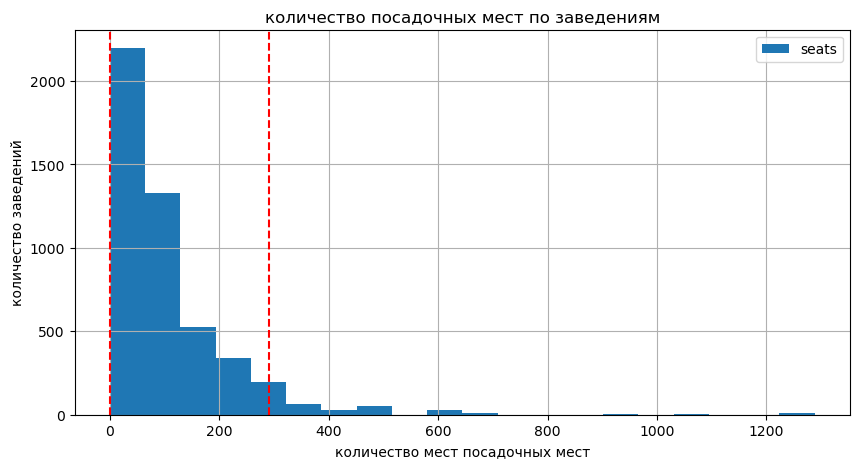

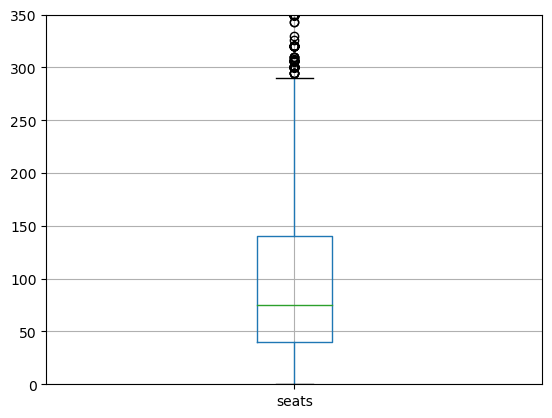

In [48]:
q3, q1 = np.percentile(new_data.loc[(~new_data['seats'].isna())]['seats'], [75 ,25])
iqr = q3 - q1
if 1.5*iqr > q1:
    min = new_data['seats'].min()
else:
    min = q1 - 1.5*iqr 
max = q3 + 1.5*iqr

print('Минимум: ', min)
print()
print('Максимум: ', max)


new_data.plot(kind='hist', y = 'seats', bins=20, grid=True, figsize=(10, 5))
plt.axvline(x = min, color = 'r', linestyle = 'dashed')
plt.axvline(x = max, color = 'r', linestyle = 'dashed')

plt.title('количество посадочных мест по заведениям')
plt.xlabel('количество мест посадочных мест')
plt.ylabel('количество заведений')

plt.show()

new_data.boxplot(column='seats')
plt.ylim(0, 350)
plt.show()


Т.е. у нас имеются и заведения, где нет посадочных мест вообще — это может быть и ошибка, и случай, когда заведение работает только на вынос (или есть только столики для "стоячих" мест без сидений). В тоже время есть заведения, у которых слишком большое количество посадочных мест (например, есть те, у которых более 1200 мест) - так могли приписать к заведениям, которые располагаются в фудкортах, или если речь идёт о каких-то банкетных залах, или опять же это просто ошибка. Проверить исправить это невозможно поэтому при анализе по количеству посадочных мест будем иметь ввиду, что "нормальные" значения располагаются в пределах от 0 до 290 посадочных мест.

### Дополнительный столбец с названием улиц
Добавим отдельный столбец с названием улиц.

In [49]:
new_data['street'] = new_data.apply(lambda x: x['address'].split(',')[1].strip(), axis=1)
new_data['street'].nunique()

1448

Добавлен новый столбец с названиями улиц. Всего датасет охватывает почти 1448 улиц.

### Дополнительный столбец  - 24/7
добавим столбец `is_27/7` в отношении заведений, которые работают круглосуточно и без выходных

In [50]:
# True для тех, у которых есть 'ежедневно, круглосуточно', у остальных False (в т.ч. у тех, у которых время работы неизвестно)
new_data['is_24/7'] = new_data.apply(lambda x: 'ежедневно, круглосуточно' in x['hours'], axis=1)
new_data['is_24/7'].tail(15)

8391    False
8392    False
8393    False
8394     True
8395    False
8396    False
8397    False
8398    False
8399     True
8400    False
8401    False
8402    False
8403     True
8404     True
8405     True
Name: is_24/7, dtype: bool

**Итого:**
- в исходном датасете имеется 8406 записей о заведениях общепита в Москве.
- в изначальном варианте имелось 5614 уникальных названий заведений. Поскольку среди названий могли быть неявные дубликаты, когда одно и то же название было записано разными способами, была проведена дополнительная обработка таких наименований, в результате чего было дополнительно отсеяно 134 повторяющихся наименований. Итог – уникальных названий осталось – 5480 (из них 742 сетевых заведения).
- дополнительно была проведена проверка на возможные дубликаты по наименованию и адресу (т.е. дублирование заведений с одним названием и по одним и тем же адресам) – 4 лишние строки удалены
- при проверке столбца с категориями заведений было обнаружено, что у части заведений, которые входят в сеть может быть указано несколько категорий. Поскольку в реальности такое в рамках сети такое маловероятно (т.е.  некоторые категории могут быть указаны ошибочно), то у части заведений (где, на одну категорию приходится доля более 65%) «редкие» категории были исправлены на основную (остальные не трогали, из-за неочевидности основной категории). Это затронуло 768 заведений (которые входят в 110 различных сетей).
- при проверке адресов мы убедились, что все указанные адреса относятся к Москве (во всяком случае в датасете других регионов нет)
- в столбце с административными районами не обнаружены дубликаты.
- в столбце с временем работы заведений обнаружено 535 пропусков (6,4% от всего датасета – не очень критично). Пропуски заменены на «неизвестно»
- при проверке столбцов с координатами было выявлено 64 заведения, которые располагаются по одному и тому же адресу с другими заведениями. При этом был обнаружен один дубликат, который был успешно удалён.
- при обработке столбца с сетями было обнаружено, что у части заведений, чьи названия в большинстве случаев отмечены сетями, в отдельных случаях отметка «сеть» не была указана (таких заведений было 56). Обработаны были только те наименования, у которых доля заведений с отметкой сеть была больше 50%
- в столбце с категорией цен обнаружено много пропусков (5086). У сетевых 2095 пропусков. Поскольку справедливым будет считать, что в рамках сети уровень цен может быть одинаков, то часть пропусков, которые пришлись на заведения входящие в сети (где более 10 заведений в сети) можно заполнить по основной категории цен, которая относится к сети. Таким образом было отработано 240 пропусков у заведений (являются частью 14 сетей)
- много пропусков в столбце со средней стоимостью заказа. Обработать возможности не было.
- в столбце с оценкой среднего чека 5252 пропуска. Часть пропусков удалось отработать по соответствующим значениям столбца `avg_bill` (обработано 132 пропуска)
. В столбце с оценкой чашки кофе пропусков 7866. Аналогичным способом их обработать не удалось.
- у столбца с количество посадочных мест 3609 пропусков – их обработать невозможно. Нормальные значения с числом посадочных мест располагаются в диапазоне от 0 до 290.
- добавлены столбцы `street` с названиями улиц и `is_24/7`, который устанавливает метки для заведений, которые работают круглосуточно и ежедневно.
- По итогам предобработки осталась 8401 строка

## Анализ данных

### Категории заведений
Посмотрим, какие есть категории и как заведения распределены по категориям.

In [51]:
# Посмотрим, какие есть категории
print('количество категорий:', new_data['category'].nunique())
new_data['category'].unique().tolist()

количество категорий: 8


['кафе',
 'ресторан',
 'кофейня',
 'пиццерия',
 'бар,паб',
 'быстрое питание',
 'булочная',
 'столовая']

Итак, у нас имеется 8 категорий заведений: кафе, рестораны, кофейни, пиццерии, бары/пабы, заведения из разряда Fast food, булочные, столовые. Посмотрим, как распределено количество заведений по категориям.

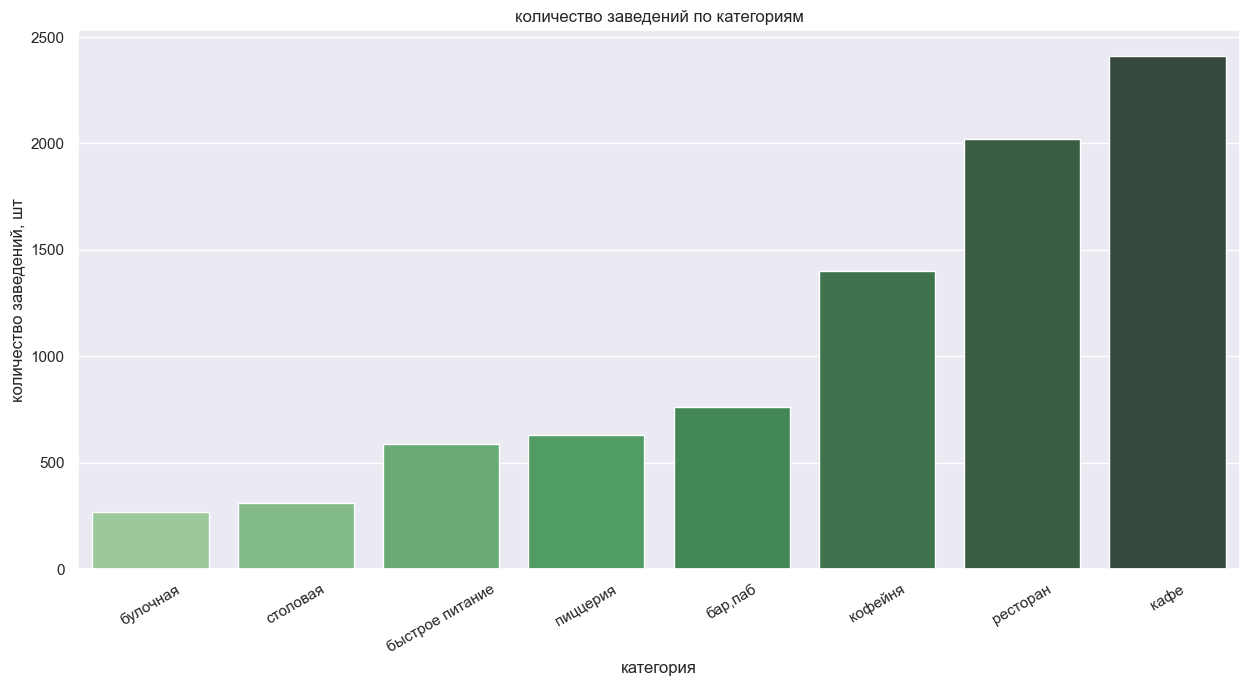

In [52]:
# Построим столбчатую диаграмму
catering_category = (
    new_data.groupby('category', as_index=False)
    .agg({'name': 'count'})
    .rename(columns={'name': 'quantity'})
    .sort_values(by='quantity')
)

plt.figure(figsize=(15, 7))

sns.set()
sns.set_palette('Greens_d', 8)

ax = sns.barplot(x='category', y = 'quantity', data=catering_category)
ax.set_title('количество заведений по категориям')
ax.set_xlabel('категория')
ax.set_ylabel('количество заведений, шт')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
    
plt.show()

In [53]:
# код графика
# Построим круговую диаграмму
# fig = go.Figure(data=[go.Pie(labels=catering_category['category'], values=catering_category['quantity'])])
# fig.update_layout(title = 'категории заведений',
#                  width = 800,
#                  height = 600,
#                  annotations=[dict(x=1.12, 
#                                    y=1.05,
#                                    text='категория заведения',
#                                    showarrow=False)])
# fig.show()

*скриншот графика*
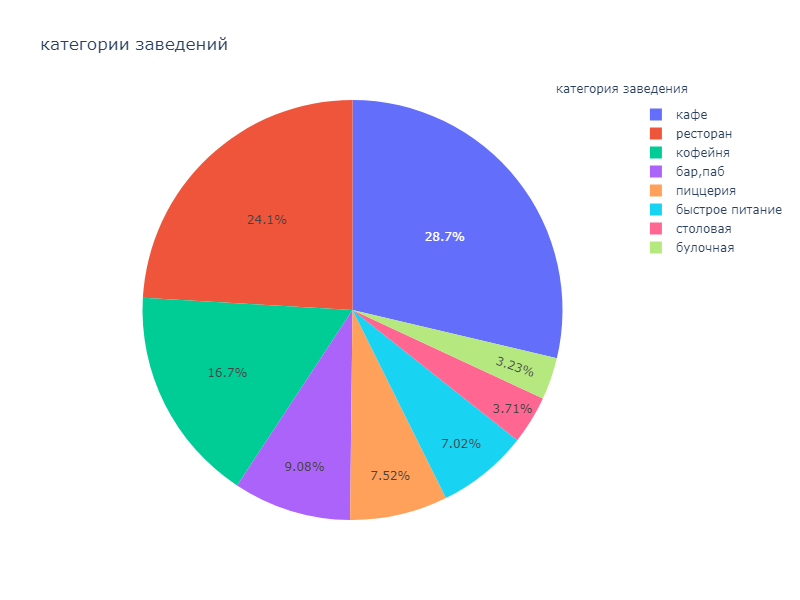

По графикам видно, что в топ-3 входят следующие категории:
- кафе (на них приходится 2411 заведений, что составляет 28,7% от общего числа заведений
- рестораны (2023 точки - 24,1%)
- кофейни (1399 заведений - 16,7%) 

На эти три категории суммарно приходится 69,5% всех заведений, указанных в датасете.
В противовес им самые малочисленные категории это булочные (271 заведение - 3,23%) и столовые (312 заведений - 3,71%)

### Количество посадочных мест
Посмотрим количество, как в среднем распределяется количество посадочных мест по категориям. При этом стоит помнить, что есть некоторые заведения, у которых указано аномально большое количество посадочных мест (что может быть или ошибкой, или реально каким-то уникальным заведением). Поэтому такие заведения отфильтруем (где посадочных мест не более 290). 

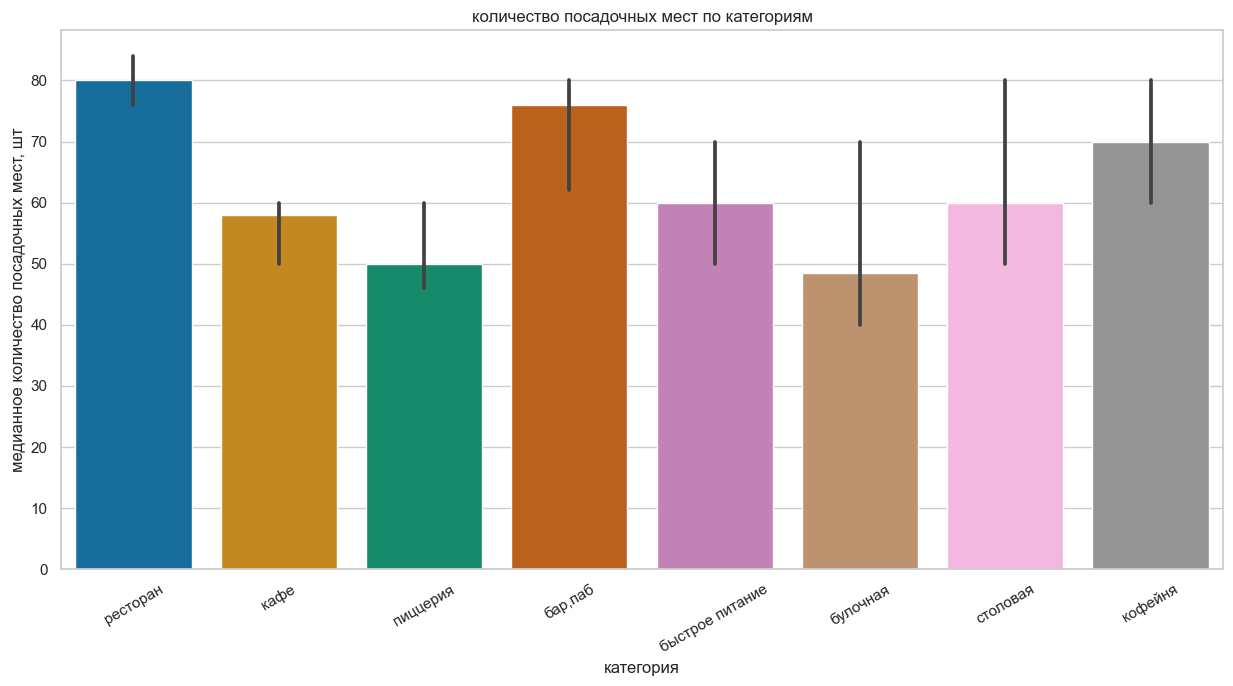

In [54]:
# отфильтруем посадочные места не более 290
filtred_data_seats = new_data.query('seats <= 290')

# строим график по категориям

plt.figure(figsize=(15, 7))

sns.set()
sns.set_style('whitegrid')
sns.set_palette('colorblind')

ax = sns.barplot(x='category', y = 'seats', data=filtred_data_seats, estimator=median)
ax.set_title('количество посадочных мест по категориям')
ax.set_xlabel('категория')
ax.set_ylabel('медианное количество посадочных мест, шт')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
    
plt.show()

Наибольшее среднее число посадочных мест имеют заведения категории "ресторан" - в среднем около 80 посадочных мест. На втором и третьем месте идут бары/пабы и кофейни (около 75 и 70 посадочных мест соответственно). Все остальные в лучшем случае еле дотягивают до 60. Наименьшее среднее количество посадочных мест у пиццерий (около 50) и у булочных (в районе 47).

### Сетевые и несетевые заведения 
Для начала просто посмотрим соотношение сетевых и несетевых заведений

In [55]:
chain_or_not = new_data.groupby('chain', as_index=False).agg({'name':'count'}).rename(columns={'name':'quantity'})

In [56]:
# код графика ниже
# строим круговую диаграмму
# fig = go.Figure(data=[go.Pie(labels=chain_or_not['chain'], values=chain_or_not['quantity'])])
# fig.update_layout(title = 'соотношение сетевых и несетевых заведений',
#                  width = 800,
#                  height = 600,
#                  annotations=[dict(x=1.12, 
#                                    y=1.05,
#                                    text='принадлежность к сети',
#                                    showarrow=False)])
# fig.show()

*скриншот графика*
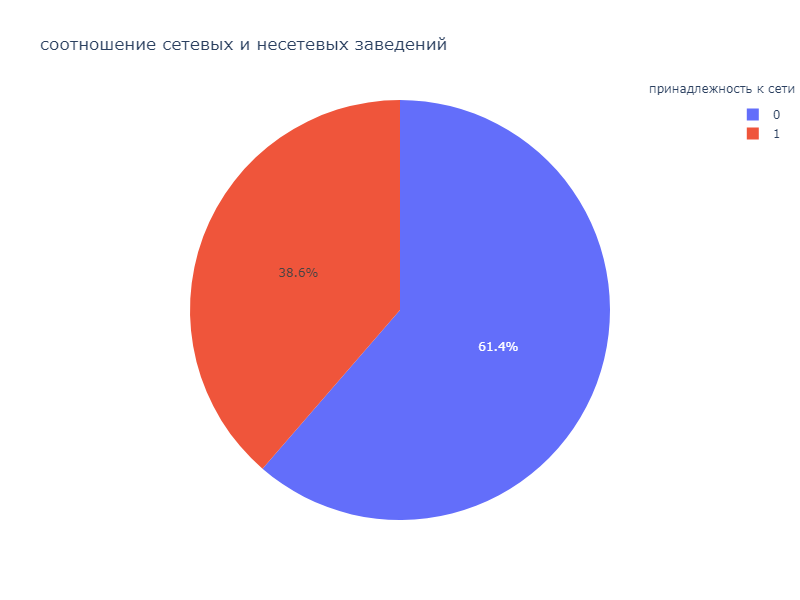

Таким образом более 60% заведений не являются частью сетей. К сетям же относится почти 39% заведений. Далее посмотрим, какими категориями чаще всего представлены сетевые заведения. 

In [57]:

# группируем сетевые по категориям
chain_category = (
    new_data[new_data['chain'] == 1]
    .groupby('category', as_index=False)
    .agg({'name':'count'})
    .rename(columns={'name':'quantity'})
    .sort_values(by='quantity', ascending=False)
)

# код графика ниже
# # строим график - круговая диаграмма

# fig = go.Figure(data=[go.Pie(labels=chain_category['category'], values=chain_category['quantity'], pull = [0.1, 0.05])])
# fig.update_layout(title = 'сетевые заведения по категориям',
#                  width = 800,
#                  height = 600,
#                  annotations=[dict(x=1.12, 
#                                    y=1.05,
#                                    text='категория',
#                                    showarrow=False)])
# fig.show()


*скриншот графика*
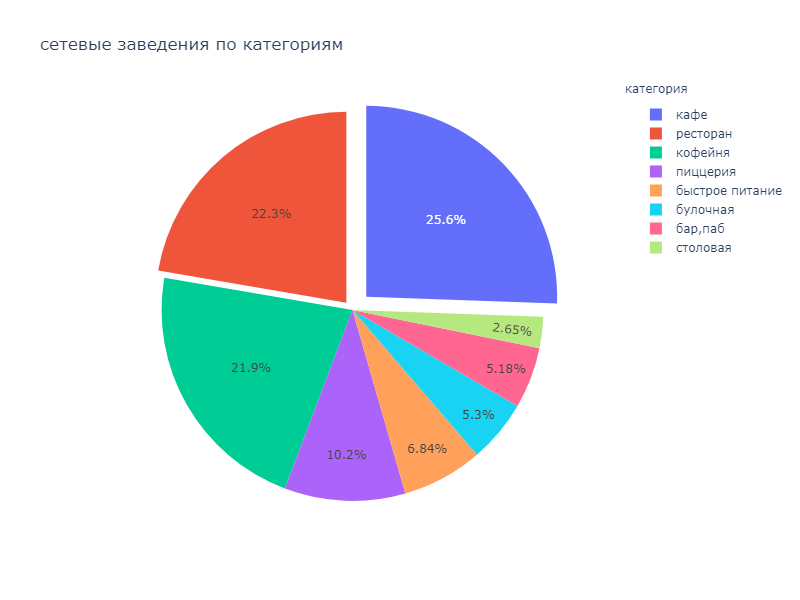

В ТОП-3 находятся категории с примерно одинаковой долей от общего числа. Чаще всего в рамках сетей представлены кафе - 25,6% от общего количества сетевых заведений. На втором месте находятся рестораны -22,2%, на третьем - кофейни (21,8%). Реже всего представителями сетей являются столовые  всего 2,88%. Далее посмотрим наиболее популярные сети (соберём топ-15).  

Далее посмотрим, какую долю составляют сетевые заведения в общем количестве в разрезе по категориям.

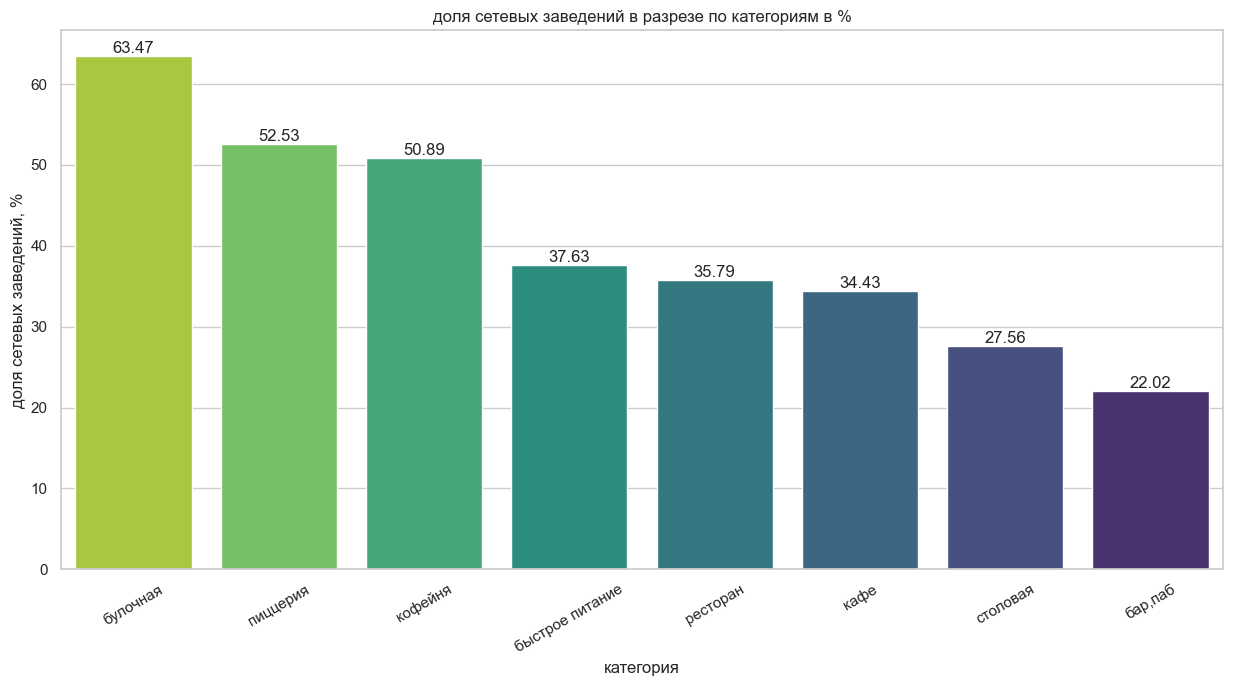

In [58]:
# сгруппируем заведения по категориям подсчитав долю сетевых в каждой категории
share_chain_category = (
    new_data.groupby('category', as_index=False)
    .agg({'chain': 'mean'})
    .rename(columns={'chain': 'share_of_chane_%'})
    .sort_values(by='share_of_chane_%', ascending=False)
)
share_chain_category['share_of_chane_%'] = round(share_chain_category['share_of_chane_%']*100, 2)

# строим график с долями в разрезе по категориям 

plt.figure(figsize=(15, 7))

sns.set()
sns.set_style('whitegrid')
# sns.set_palette('colorblind')
sns.set_palette(sns.color_palette("viridis_r", 8))

ax = sns.barplot(x='category', y = 'share_of_chane_%', data=share_chain_category)
ax.set_title('доля сетевых заведений в разрезе по категориям в %')
ax.set_xlabel('категория')
ax.set_ylabel('доля сетевых заведений, %')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
ax.bar_label(ax.containers[0])    
plt.show()

В разрезе по категориям видено следующее:
- наибольший процент сетевых заведений можно наблюдать у категории "булочная" (63.47%). 
- также довольно часто в рамках сетей развиваются пиццерии (52.53%) и кофейни (50.89%)
- реже всего сетями являются столовые (27.56%) и бары (22.02%)

In [59]:

top_chains = (
    new_data[new_data['chain'] == 1]
    .groupby('name', as_index=False)
    .agg({'address':'count'})
    .rename(columns={'address':'quantity'})
    .sort_values(by='quantity', ascending=False)
    .head(15)
)
# код графика ниже
# # строим график 
# fig = px.bar(top_chains.sort_values(by='quantity', ascending=True), 
#              x='quantity',
#              y='name',
#              text='quantity' 
#             )

# fig.update_layout(title='ТОП-15 популярных сетевых заведений',
#                    xaxis_title='Количество заведений',
#                    yaxis_title='название сети')
# fig.show() 

*скриншот графика*
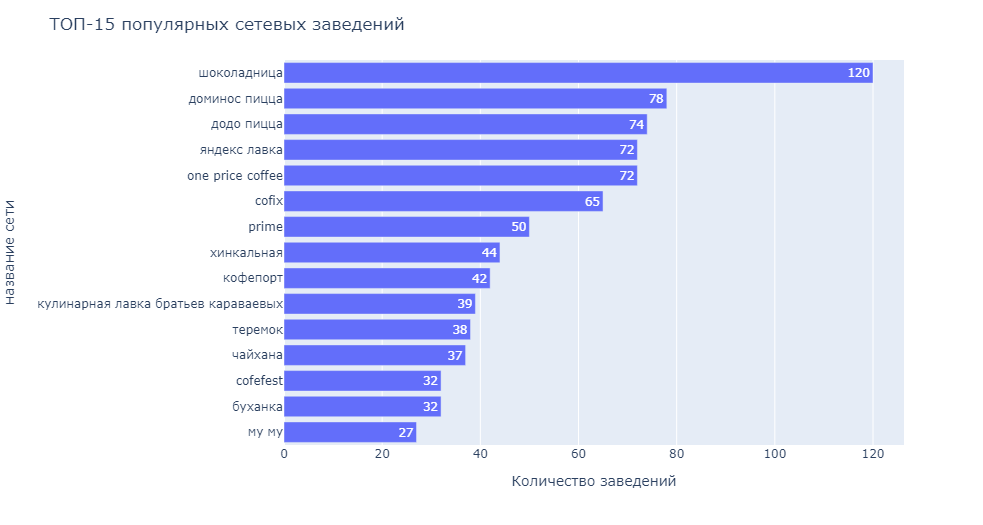

Самым популярным заведением является кофейня Шоколадница. Также среди достаточно известные пиццерии (Доминос пицца и До-до пицца), достаточно распространённые кофейни One price coffee и Cofix. В целом можно предположить, что в первую очередь речь идёт о достаточно узкоспециализированных, относительно недорогих и не самых больших заведениях (во всяком случае на первый взгляд здесь не наблюдается очень крупных и дорогих ресторанов или баров)

In [60]:
# код графика ниже
# собираем категории, в которые попадают топ-15 сетей
categories_top_chains = (
    new_data[new_data['name'].isin(top_chains['name'].unique())]
    .groupby('category', as_index=False)
    .agg({'name': 'count'})
    .rename(columns={'name':'quantity'})
    .sort_values(by='quantity', ascending=False)
)

# fig = go.Figure(data=[go.Pie(labels=categories_top_chains['category'],
#                              values=categories_top_chains['quantity'],
#                              pull = [0.1, 0])])
# fig.update_layout(title = 'Категории ТОП-15 популярных заведений',
#                  width = 800,
#                  height = 600,
#                  annotations=[dict(x=1.12, 
#                                    y=1.05,
#                                    text='категория',
#                                    showarrow=False)])
# fig.show()


*скриншот графика*
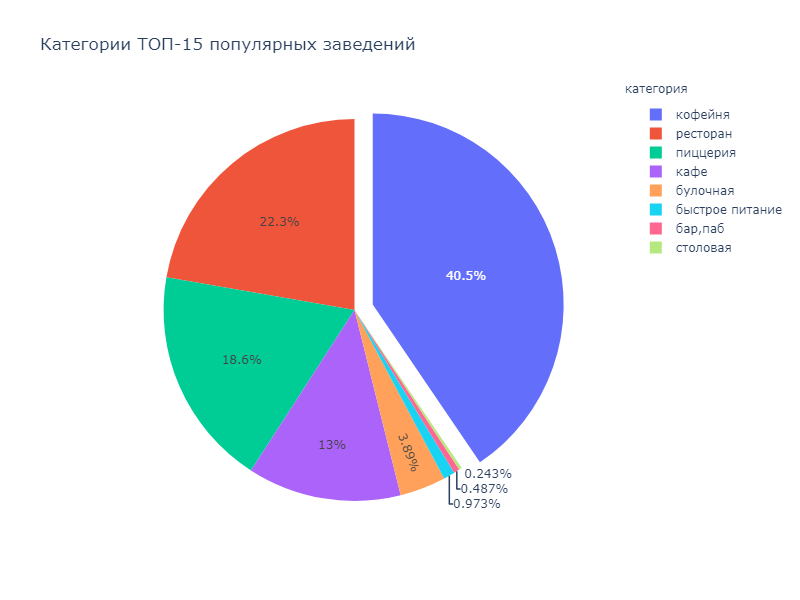

40,5% заведений из ТОП-15 — это кофейни. Достаточно большая доля пришлась и на рестораны (22,3%), но тут стоит сделать скидку на то, что сами по себе рестораны могут быть достаточно разношёрстны и к ним могут относится заведения совершенно разной направленности и разной ценовой категории. Также большие доли сохраняются у пиццерий (18,6%) и у кафе (13%). На остальные категории приходится совсем маленькая доля - около 5,6% (меньше всего у столовых - 0,243%

### Заведения по районам
Ещё взглянем, какие административные районы у нас есть в датасете и как заведения распределены по районам, в т.ч. в разрезе по категориям

In [61]:
district_category = new_data.groupby(['district', 'category'], as_index=False).agg({'name': 'count'}).rename(columns={'name': 'quantity'})
district_category['total_for_district'] = district_category.groupby('district')['quantity'].transform('sum')
district_category

district         category  quantity  \
0   Восточный административный округ          бар,паб        54   
1   Восточный административный округ         булочная        24   
2   Восточный административный округ  быстрое питание        69   
3   Восточный административный округ             кафе       278   
4   Восточный административный округ          кофейня       104   
..                               ...              ...       ...   
67      Южный административный округ             кафе       267   
68      Южный административный округ          кофейня       128   
69      Южный административный округ         пиццерия        74   
70      Южный административный округ         ресторан       198   
71      Южный административный округ         столовая        44   

    total_for_district  
0                  797  
1                  797  
2                  797  
3                  797  
4                  797  
..                 ...  
67                 892  
68                 892  
69                 892  
70                 892  
71                 892  

[72 rows x 4 columns]

In [62]:
# код графика ниже
# сгруппируем по районам и столбцам
district_category = new_data.groupby(['district', 'category'], as_index=False).agg({'name': 'count'}).rename(columns={'name': 'quantity'})
district_category['total_for_district'] = district_category.groupby('district')['quantity'].transform('sum')
# сделаем график
# fig = px.bar(district_category.sort_values(by='total_for_district'), 
#              x='quantity',
#              y='district',
#              color = 'category',
#              text_auto=True             
#             )

# fig.update_layout(title='количество заведений по районам по категориям',
#                    xaxis_title='Количество заведений',
#                    yaxis_title='район',
#                    annotations=[
#                              {"y": x, "x": total,
#                               'text': 'Total: '+str(total),
#                               "showarrow": False, "xshift": 100,
#                               "font": dict(family="Courier New, monospace", size=16, color="#000001")} 
#                        for x, total in new_data.groupby('district', as_index=False).agg(count_object=('name', 'count')).values]                 
#                  )
# fig.show()

*скриншот графика*
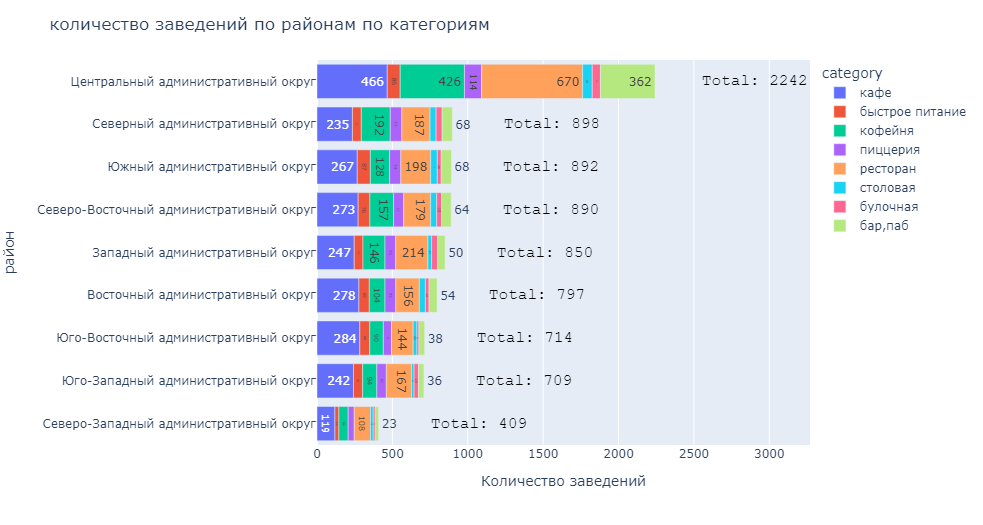

Подавляющее число заведений располагается в центральном районе (2242 заведения). В этом районе основными категориями являются рестораны (670), кафе (466), кофейни (426) и бары (362). В остальных районах количество заведений из датасета значительно меньше: в четырёх - от 850 до 900, в трёх - от 700 до 800, и в одном (С-З округ) - всего 409 заведений. Почти во всех остаётся примерно одинаковый топ-3 категорий заведений - кафе, рестораны и кофейни. При этом во всех случаях (кроме ЦАО) лидирующую позицию занимают кафе, а вот соотношение ресторанов и кофеен разное в разных районах (но в большинстве случае преимущество у ресторанов, хотя нельзя сказать, что разница очень большая. В целом ситуация по районам примерно совпадает с тем, что мы видели в пункте 3.1, когда смотрели на распределение по категориям в городе в целом.

### Рейтинги заведений
Посмотрим, какие райтинги ставят заведениям в разрезе по категориям

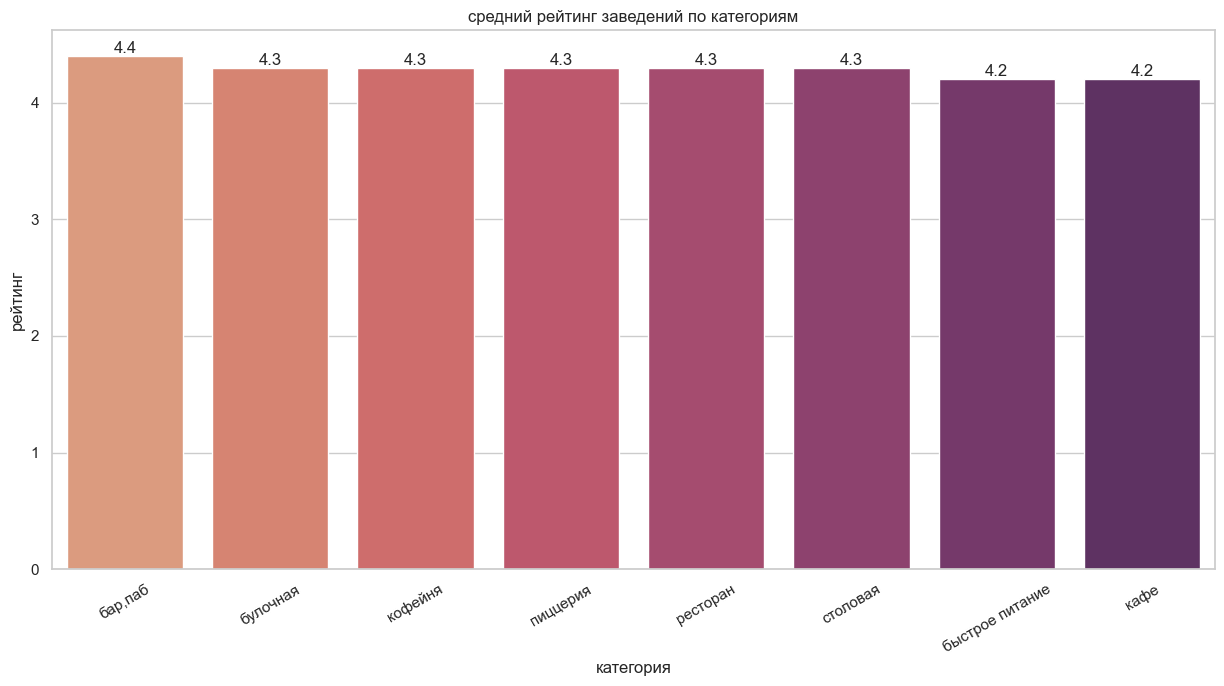

In [63]:
# группируем данные (брать будем медианный рейтинг для категории)
rating_category = (
    new_data.groupby('category', as_index=False)
    .agg({'rating': 'median'})
    .sort_values(by='rating', ascending=False)
)

# строим график по категориям

plt.figure(figsize=(15, 7))

sns.set()
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('flare', 8))

ax = sns.barplot(x='category', y = 'rating', data=rating_category)
ax.set_title('средний рейтинг заведений по категориям')
ax.set_xlabel('категория')
ax.set_ylabel('рейтинг')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
ax.bar_label(ax.containers[0])

plt.show()

Мы видим, что в целом средние оценки у всех категории +/- одинаковые - от 4.2 до 4.4 баллов. Самый высокий балл у баров (4.4), минимальный - у заведений быстрого питания и у кафе. Но в целом оценить целую категорию по среднему рейтингу не слишком показательно - принципиальной разницы (по крайней мере в данном масштабе не видно)

### Картограмма со средним рейтингом заведений по районам.

In [64]:
# сначала сгруппируем средний рейтинг заведений по административным районам 
rating_district = new_data.groupby('district', as_index=False).agg({'rating': 'median'})
rating_district

district  rating
0         Восточный административный округ     4.3
1          Западный административный округ     4.3
2          Северный административный округ     4.3
3  Северо-Восточный административный округ     4.2
4   Северо-Западный административный округ     4.3
5       Центральный административный округ     4.4
6     Юго-Восточный административный округ     4.2
7      Юго-Западный административный округ     4.3
8             Южный административный округ     4.3

In [65]:
#  код графика ниже
# загружаем JSON-файл с границами округов Москвы

state_geo = 'https://code.s3.yandex.net/data-analyst/admin_level_geomap.geojson'

# # moscow_lat - широта центра Москвы, moscow_lng - долгота центра Москвы
# moscow_lat, moscow_lng = 55.751244, 37.618423

# # создаём карту Москвы
# m = Map(location=[moscow_lat, moscow_lng], zoom_start=10,  tiles='Open street map')

# # создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
# Choropleth(
#     geo_data=state_geo,
#     data=rating_district,
#     columns=['district', 'rating'],
#     key_on='feature.name',
#     fill_color='YlOrRd',
#     fill_opacity=0.5,
#     legend_name='Медианный рейтинг заведений по районам',
    
# ).add_to(m)

# m

*скриншот графика*
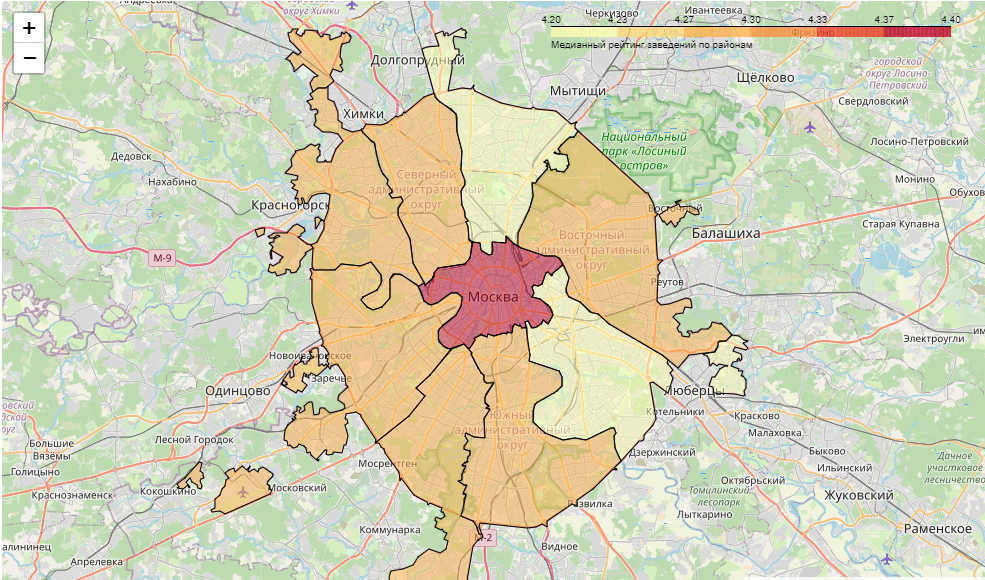

По полученной карте можно видеть, что заведения с наиболее высоким рейтингом (около 4.4) располагаются в Центральном районе. Самый низкий средний рейтинг у Юго-восточного административного округа и Северо-восточного административного округа (в районе 4.2). Остальные районы имеют средний рейтинг около 4.3

### Все заведения общепита на карте
Сформируем карту со всеми заведениями общепита

In [66]:
# код графика ниже
# # ещё раз создадим канрту Москвы
# m2 = Map(location=[moscow_lat, moscow_lng], zoom_start=10,  tiles='Open street map')

# # создаём пустой кластер, добавляем его на карту
# marker_cluster = MarkerCluster().add_to(m2)

# # функция для создания кластера с заведениями
# def create_clusters(row):
#     Marker(
#         [row['lat'], row['lng']],
#         popup=f" название: {row['name']} \n\nкатегория: {row['category']} \n\nчасы работы: {row['hours']} \n\nрейтинг: {row['rating']} ",
#     ).add_to(marker_cluster)

# new_data.apply(create_clusters, axis=1)

# m2

*скриншот графика*
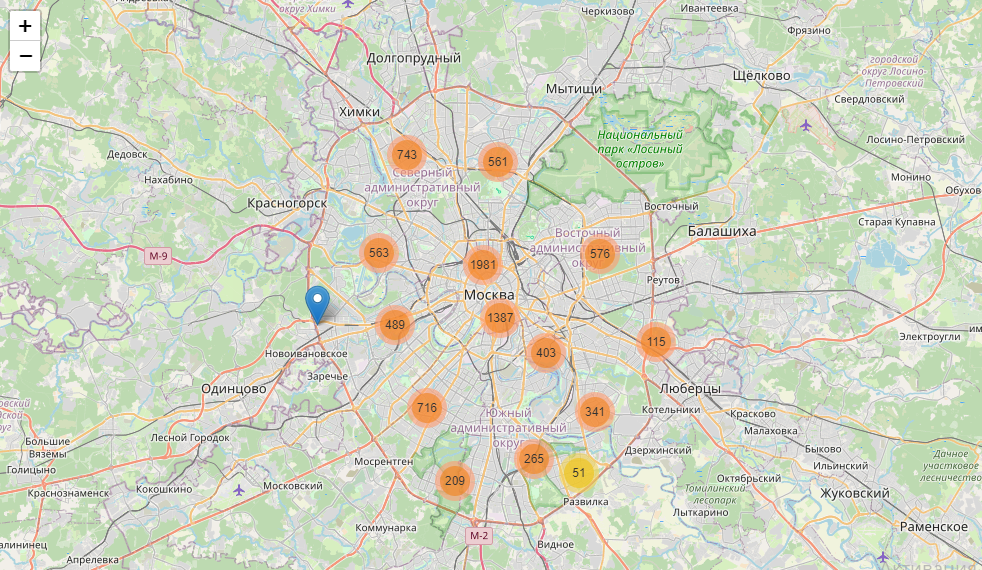

Даже невооруженным взглядом видно, что на карте очень большее количество заведений располагается в Центральном районе. Это понятно, т.к. это, по сути, центр притяжения и для туристов, и для студентов, и для сотрудников крупных компаний и просто для тех жителей кто хочет как-то провести свой досуг. Здесь есть и исторические важные места (та же Красная площадь), и крупные парки, и музеи с театрами, спортивные объекты (те же БСА "Лужники") и высшие учебные заведения. Здесь же есть и деловые центры - тот же комплекс "Москва-Сити" также располагается в этом районе. Кроме того, здесь большая концентрация станций метро, что обеспечивает достаточно активное движение населения в этом районе. Поэтому, конечно, этот район выглядит очень привлекательно для заведений общественного питания.

### Топ-15 улиц по числу заведений
Посмотрим, где самые "населённые" улицы с точки зрения числа заведений, которые там находятся.

In [67]:
#  группируем по улицам
street_catering = (
    new_data.groupby(['street', 'category'], as_index=False)
    .agg({'name':'count'})
    .rename(columns={'name': 'quantity'})
)
street_catering['total_by_street'] = street_catering.groupby('street')['quantity'].transform('sum')

top_15_streets = (
    street_catering.groupby('street', as_index=False)
    .agg({'total_by_street': 'mean'})
    .sort_values(by='total_by_street', ascending=False).head(15)['street'].unique()
)

# код графика ниже
# # сделаем график
# fig = px.bar(street_catering.query('street in @top_15_streets').sort_values(by='total_by_street'), 
#              x='quantity',
#              y='street',
#              color = 'category',
#              text_auto=True             
#             )

# fig.update_layout(title='ТОП-15 улиц по количеству заведений по категориям',
#                    xaxis_title='Количество заведений',
#                    yaxis_title='улица',
#                    annotations=[
#                              {"y": x, "x": total,
#                               'text': 'Total: '+str(total),
#                               "showarrow": False, "xshift": 100,
#                               "font": dict(family="Courier New, monospace", size=16, color="#000001")} 
#                        for x, total in (
#                            new_data.query('street in @top_15_streets')
#                            .groupby('street', as_index=False)
#                            .agg(count_object=('name', 'count')).values)]                 
#                  )
# fig.show()


*скриншот графика*
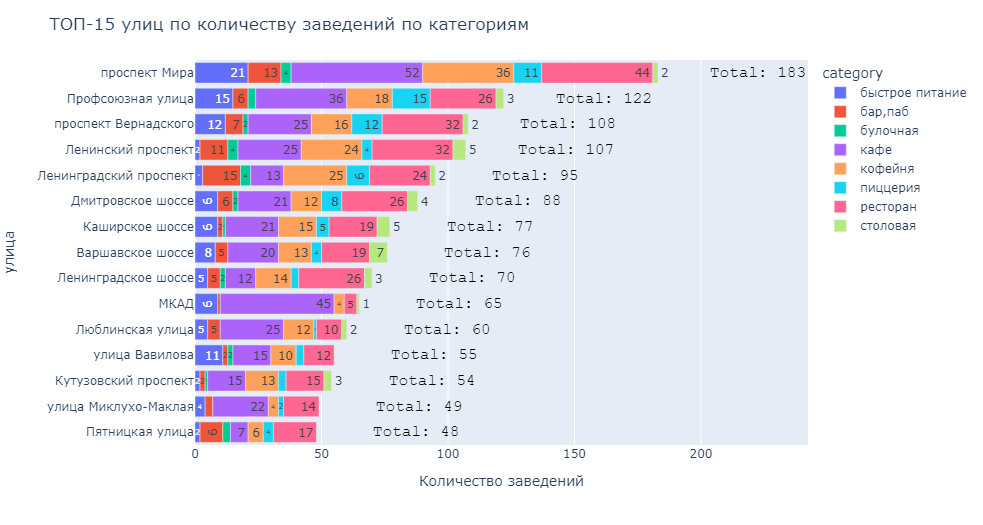

На основе этого графика можно сделать вывод, что больше всего заведений располагаются на проспекте Мира. На этой улице основными категориями, которыми представлены заведения, являются "кафе" (52шт), "рестораны" (44шт) и "кофейни" (36шт). На остальных улицах топ-3 категорий практически везде (за редким исключением таким же), хотя их соотношение может быть разным. Можно отметить интересное положение на МКАДе - там подавляющее большинство заведений - это кафе (45 заведений из 65). В некоторых редких отдельных случаях неплохую долю могут показывать бары или заведения быстрого питания. Однозначно во всех случаях очень слабо представлены столовые и булочные. Но общая тенденция сохраняется: ТОП-3 - кафе, рестораны и кофейни.

### Улицы с наименьшим количеством заведений
Посмотрим улицы, где есть только одно заведение

In [68]:
worst_streets = street_catering.query('total_by_street == 1')['street'].unique()
len(worst_streets)

458

Таких улиц 458. Посмотрим в какие категории попадают заведения на данных улицах.

In [69]:
worst_streets_category = (
    new_data[new_data['street'].isin(worst_streets)].groupby('category', as_index=False)
    .agg({'name': 'count', 'rating': 'median'})
    .rename(columns={'name': 'quantity'})
    .sort_values(by='quantity', ascending=False)
)
worst_streets_category

category  quantity  rating
3             кафе       160    4.20
6         ресторан        92    4.30
4          кофейня        83    4.30
0          бар,паб        39    4.50
7         столовая        36    4.30
2  быстрое питание        23    4.30
5         пиццерия        16    4.35
1         булочная         9    4.30

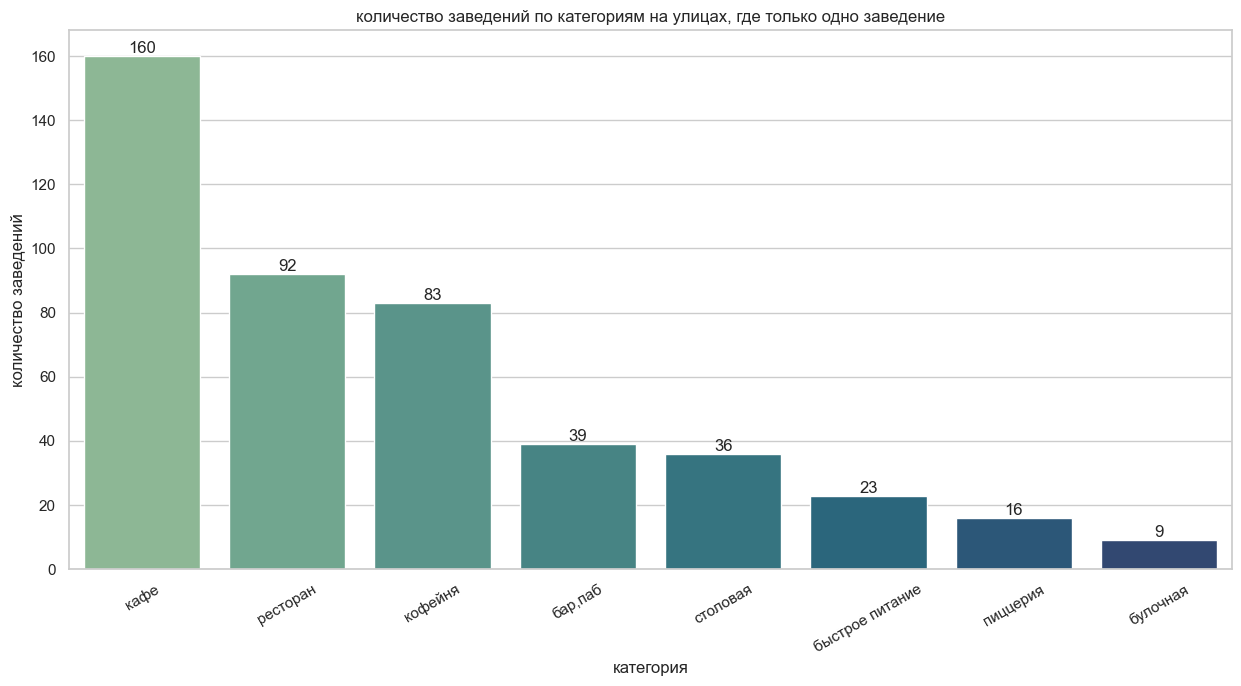

In [70]:
# строим график по категориям

plt.figure(figsize=(15, 7))

sns.set()
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('crest', 8))

ax = sns.barplot(x='category', y = 'quantity', data=worst_streets_category)
ax.set_title('количество заведений по категориям на улицах, где только одно заведение')
ax.set_xlabel('категория')
ax.set_ylabel('количество заведений')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
ax.bar_label(ax.containers[0])

plt.show()

В ситуациях, когда на улицах есть только одно заведение, чаще всего таким заведением является кафе. Также довольно нередко в такой ситуации оказываются рестораны и кофейни. Реже всего булочные. Кроме того, можно обратить внимание, что общее количество заведений категории "кафе", которые являются единственным заведением на улице, меньше чем общее количество заведений на проспекте Мира.

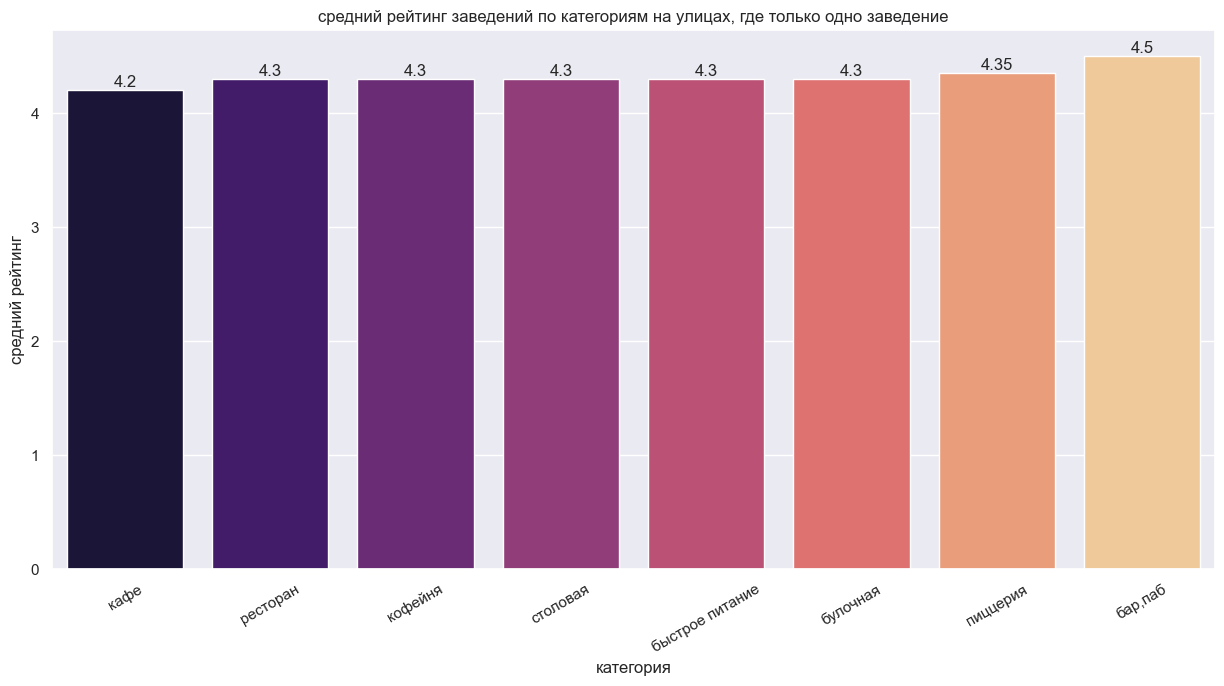

In [71]:
# строим график по категориям (по рейтингам)

plt.figure(figsize=(15, 7))

sns.set()
sns.set_style('darkgrid')
sns.set_palette(sns.color_palette('magma', 8))

ax = sns.barplot(x='category', y = 'rating', data=worst_streets_category.sort_values(by='rating'))
ax.set_title('средний рейтинг заведений по категориям на улицах, где только одно заведение')
ax.set_xlabel('категория')
ax.set_ylabel('средний рейтинг')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30)
ax.bar_label(ax.containers[0])

plt.show()

Когда речь идёт, о том, что на улице только одно заведение, то можно заметить, что средний рейтинг как правило чуть выше, чем в целом по городу по категориям, хотя соотношение примерно одинаковое. (повышенный рейтинг для таких заведений можно объяснить отсутствием конкуренции в рамках одной улицы)

### Средние чеки
Посмотрим на уровень среднего чека по районам.

In [72]:
# district_avg_bill = new_data.groupby('district', as_index=False).agg({'middle_avg_bill': 'median'})

# # создаём карту Москвы
# m3 = Map(location=[moscow_lat, moscow_lng], zoom_start=10,  tiles='Open street map')

# # создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
# Choropleth(
#     geo_data=state_geo,
#     data=district_avg_bill,
#     columns=['district', 'middle_avg_bill'],
#     key_on='feature.name',
#     fill_color='Oranges',
#     fill_opacity=0.7,
#     legend_name='средний чек заведений по районам',
# ).add_to(m3)

# m3

*скриншот графика*
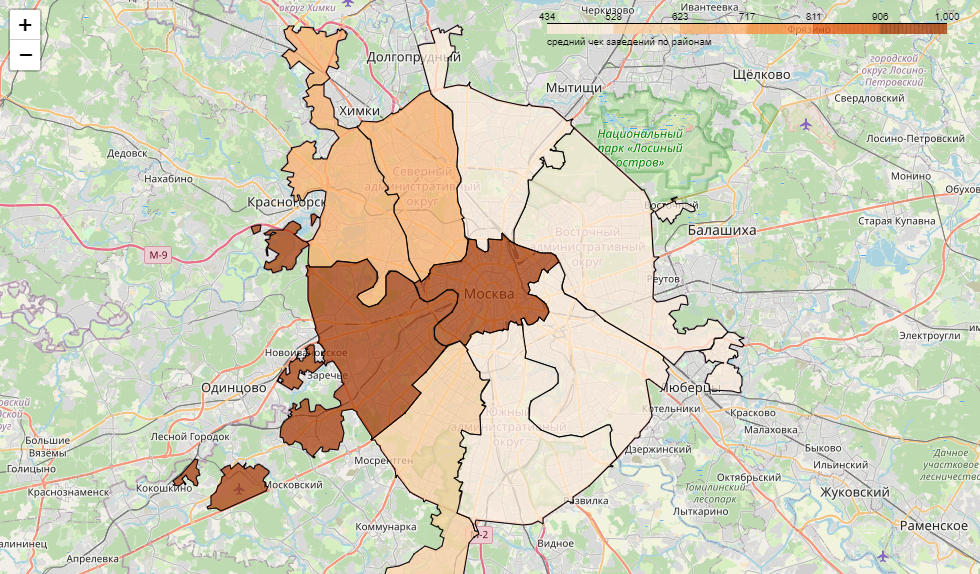

Что можно видеть по карте:
- самый дорогой район - Центральный (ожидаемо)
- на втором месте Западный административный округ. Далее в рейтинге - Северный и Северо-западный округа.
- в целом можно заметить, что восточная часть Москвы более "дешёвая", чем западная.
Таким образом: чем ближе к центру, тем дороже заведения.

### Итоги по разделу:
- Датасете представлены 8 различных вариантов категорий заведений (кафе, рестораны, кофейни, пиццерии, бар/паб, заведения быстрого питания, булочные и столовые). В топ-3 по числу представленных заведений входят «кафе» (составляют 28,7% от всего количества заведений), рестораны (24,1%) и кофейни (16,7%). Слабее всего представлены булочные (3,23%) и столовые (3,71%).  
- По количеству посадочных мест лидирует категория «ресторан» (в среднем около 80 мест), второе и третье места занимают бары и кофейни (около 75 и 70 мест в среднем) меньше всего у пиццерий (около 50) и у булочных (в районе 47).  
- Почти 39% заведений датасета являются представителями каких-то сетей. Соответственно на несетевые заведения приходится 61%. При этом среди сетевых заведений в большей степени преобладают кафе (25,6%), рестораны (22,3%) и кофейни (21,9%).  Самая малочисленная сетевая категория – столовые (2,65%). Также стоит отметить, что наибольший процент сетевых заведений можно наблюдать у категории "булочная" (63.47%). Также довольно часто в рамках сетей развиваются пиццерии (52.53%) и кофейни (50.89%); реже всего сетями являются столовые (27.56%) и бары (22.02%)
- Самыми популярными сетями (с точки зрения количества заведений) являются кофейня «Шоколадница» (почти 120 заведений), пиццерии «Доминос пицца» и «додо пицца», «яндекс лавка», достаточно распространённые кофейни  «one price coffee» и «cofix». 40% заведений из топ-15 сетевых – это кофейни. Также достаточно большие доли имеют рестораны (22,3%), пиццерии (18,6%) и кафе (13%).  
- При анализе заведений по районам можно сделать вывод, что подавляющее число заведений находится в центральном районе (2242 заведения). В этом районе основными категориями являются рестораны (670), кафе (466), кофейни (426) и бары (362).  При этом у остальных районов количество заведений примерно одинаковое (от 700 до 900 заведений). Самый малочисленный район в плане количества заведений – Северо-Западный административный округ – всего 409 заведений. Почти во всех остаётся примерно одинаковый топ-3 категорий заведений - кафе, рестораны и кофейни. При этом во всех случаях (кроме ЦАО: там лидеры - рестораны) лидирующую позицию занимают кафе.  
- Явных различий в среднем рейтинге у категорий заведений не наблюдается – средний рейтинг укладывается в диапазон от 4.2 до 4.4 баллов. Самый высокий средний балл у баров (4.4), самые низкие оценки – у кафе (4.2) и у заведений быстрого питания (4.2). У остальных средний рейтинг 4.3.  
- При этом заведения с наиболее высоким рейтингом (в среднем около 4.4 баллов) располагаются в большинстве своём в центральном районе. Самые низкие рейтинги у заведений Северо-Восточного и Юго-восточного административных округов (около 4.2). У остальных районов средний рейтинг примерно одинаковый – в районе 4.3.  
- Больше всего заведений находится на проспекте Мира – 183 заведения. Также достаточно большое количество заведений находится Профсоюзной улице, проспекте Вернадского и Ленинском проспекте (в каждом случае имеется более 100 заведений). При этом в большинстве случаев в разрезе по категориям как правило на улицах тройку лидеров (за редкими исключениями) удерживают кафе, рестораны и кофейни.  
- Стоит отметить, что имеется 458 улиц, на которых располагается только одно заведение. В подавляющем большинстве случае это заведения из категории «кафе» (160 заведений), «рестораны» (92шт) и «кофейни» (83шт). Меньше всего таких заведений представлены категориями «булочные» и «пиццерии». При этом на таких улицах средний рейтинг у заведений как правило чуть выше, чем в целом по городу. Самый высокий рейтинг у баров – 4,5, самый низкий у кафе – 4,2.  
- По размеру среднего чека в разрезе по районам лидируют центральный округ и западный. При этом стоит отметить, что восточные районы в среднем дешевле, чем западные.    


## Кофейни

### Расположение кофеен
Взглянем на расположение кофеен

In [73]:
# посчитаем количесвто кофеен
len(new_data[new_data['category'] == 'кофейня'])

1399

В Москве по имеющемуся датасету есть 1399 кофеен. Посмотрим, как они располагаются на карте.

In [74]:
# сгруппируем по районам количество кофеен
dicstrict_coffee = (
    new_data.query('category == "кофейня"')
    .groupby('district', as_index=False)
    .agg({'name':'count'})
    .rename(columns={'name': 'quantity'})
    .sort_values(by='quantity', ascending=False)
)
dicstrict_coffee

district  quantity
5       Центральный административный округ       426
2          Северный административный округ       192
3  Северо-Восточный административный округ       157
1          Западный административный округ       146
8             Южный административный округ       128
0         Восточный административный округ       104
7      Юго-Западный административный округ        94
6     Юго-Восточный административный округ        90
4   Северо-Западный административный округ        62

In [75]:
# # еще раз задаём карту Москвы
# m4 = Map(location=[moscow_lat, moscow_lng], zoom_start=10,  tiles='Open street map')

# # создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
# Choropleth(
#     geo_data=state_geo,
#     data=dicstrict_coffee,
#     columns=['district', 'quantity'],
#     key_on='feature.name',
#     fill_color='YlGnBu',
#     fill_opacity=0.7,
#     legend_name='Количество кофеен по районам',
# ).add_to(m4)


# m4

*скриншот графика*
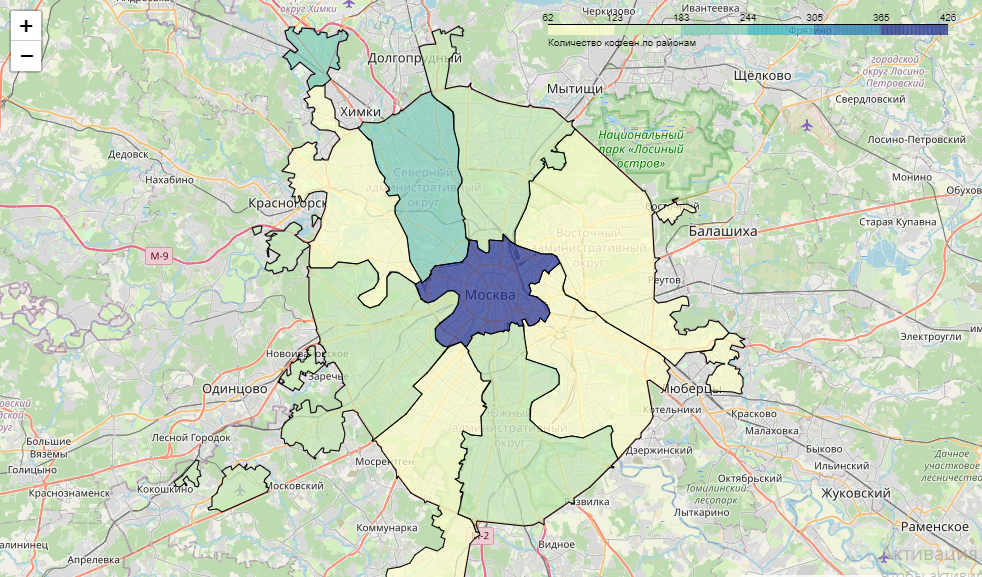

Однозначно лидером по количеству кофеен является Центральный административный район (426 заведений). Вероятно, может быть связано с различными местами притяжения как жителей Москвы, так и для туристов: это и исторические места (та же Красная площадь) и крупные парки, и театры, и музеи, и ВУЗы и деловые центры и т.д. С приличным отставанием далее идёт Северный административный округ - 192 заведения (хотя по площади его нельзя назвать достаточно большим). Меньше всего кофеен в Восточном, Юго-Западном, Юго-Восточном и Северо-Западном административных округах, хотя по площади эти районы достаточно крупные.

### Круглосуточные кофейни

In [76]:
# посмотрим есть ли круглосутчоные кофейни
coffee_24_7 = (
    new_data.query('category == "кофейня"')
    .groupby('is_24/7', as_index=False)
    .agg({'name':'count'})
    .rename(columns={'name': 'quantity'})
    .sort_values(by='quantity', ascending=False)
)
coffee_24_7['working_hours'] = coffee_24_7.apply(lambda x: 'круглосуточно' if x['is_24/7'] else 'не круглосуточно', axis=1)
coffee_24_7

is_24/7  quantity     working_hours
0    False      1338  не круглосуточно
1     True        61     круглосуточно

In [77]:
#  сделаем круговую диаграмму
# fig = go.Figure(data=[go.Pie(labels=coffee_24_7['working_hours'],values=coffee_24_7['quantity'])])
# fig.update_layout(title = 'кофейни круглосуточные и не круглосуточные',
#                  width = 800,
#                  height = 600,
#                  annotations=[dict(x=1.12, 
#                                    y=1.05,
#                                    text='режим работы',
#                                    showarrow=False)])
# fig.show()


*скриншот графика*
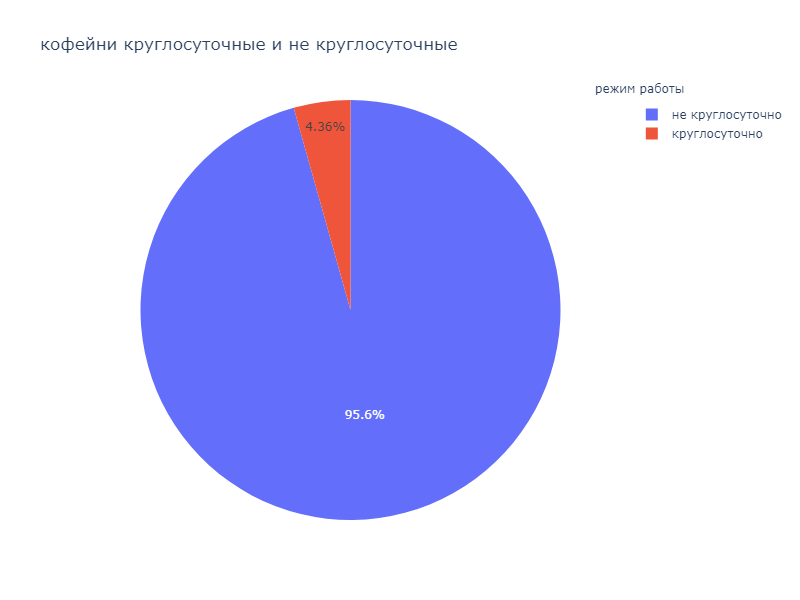

Итак, всего 4,36% кофеен (61 заведение) работает круглосуточно, что в принципе объяснимо - не так уж много людей предпочтут пойти ночью в кофейню (скорее в бар). 

### Рейтинг кофеен по районам
Ранее мы уже видели, что средний рейтинг у кофеен - 4.3. Посмотрим, как рейтинг кофеен распределяется по районам.

In [78]:
coffee_rating = (
    new_data.query('category == "кофейня"')
    .groupby('district', as_index=False)
    .agg({'rating':'mean'})
    .sort_values(by='rating', ascending=False)
)
coffee_rating

district    rating
5       Центральный административный округ  4.336620
4   Северо-Западный административный округ  4.325806
2          Северный административный округ  4.292187
0         Восточный административный округ  4.280769
7      Юго-Западный административный округ  4.273404
8             Южный административный округ  4.229687
6     Юго-Восточный административный округ  4.218889
3  Северо-Восточный административный округ  4.214013
1          Западный административный округ  4.190411

In [79]:
# # ещё раз зададим карту Москвы
# m5 = Map(location=[moscow_lat, moscow_lng], zoom_start=10,  tiles='Open street map')

# # создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
# Choropleth(
#     geo_data=state_geo,
#     data=coffee_rating,
#     columns=['district', 'rating'],
#     key_on='feature.name',
#     fill_color='YlOrRd',
#     fill_opacity=0.5,
#     legend_name='Медианный рейтинг кофеен по районам',
# ).add_to(m5)

# m5

*скриншот графика*
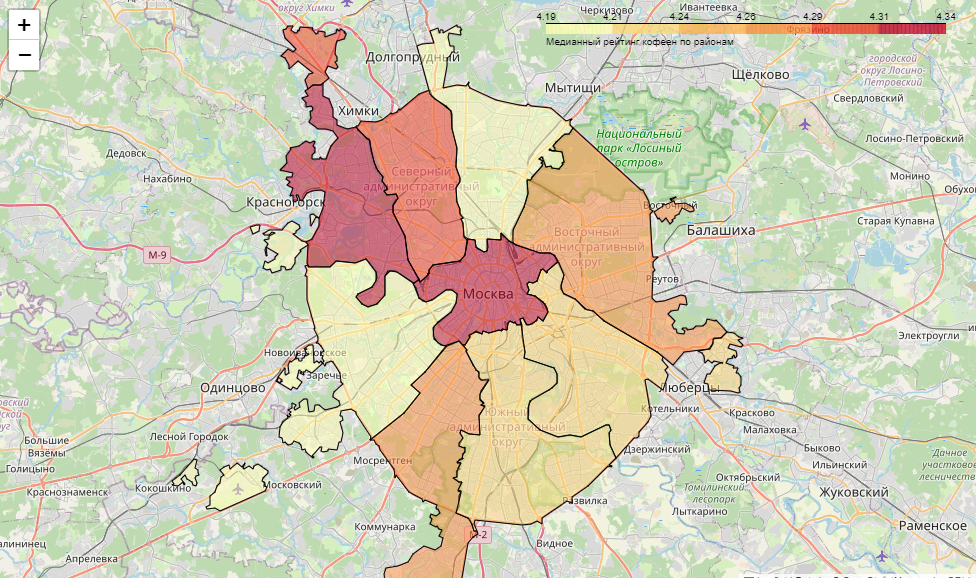

Рейтинг кофеен распределён очень неравномерно. Так в Центральном и Северо-Западном районах средний рейтинг выше 4.32 балла. У Северного, Юго-Западного и Восточных районов - от 4.27 до 4.30. Южный и Юго-Восточный районы - около 4.22. Самый низкий рейтинг у Северо-Восточного и Западного округов - от 4.19 до примерно 4.21

### стоимость чашки капучино.

q1:  124.5

q3:  225.0
Минимум:  60.0

Медиана:  169.0

Максимум:  375.75


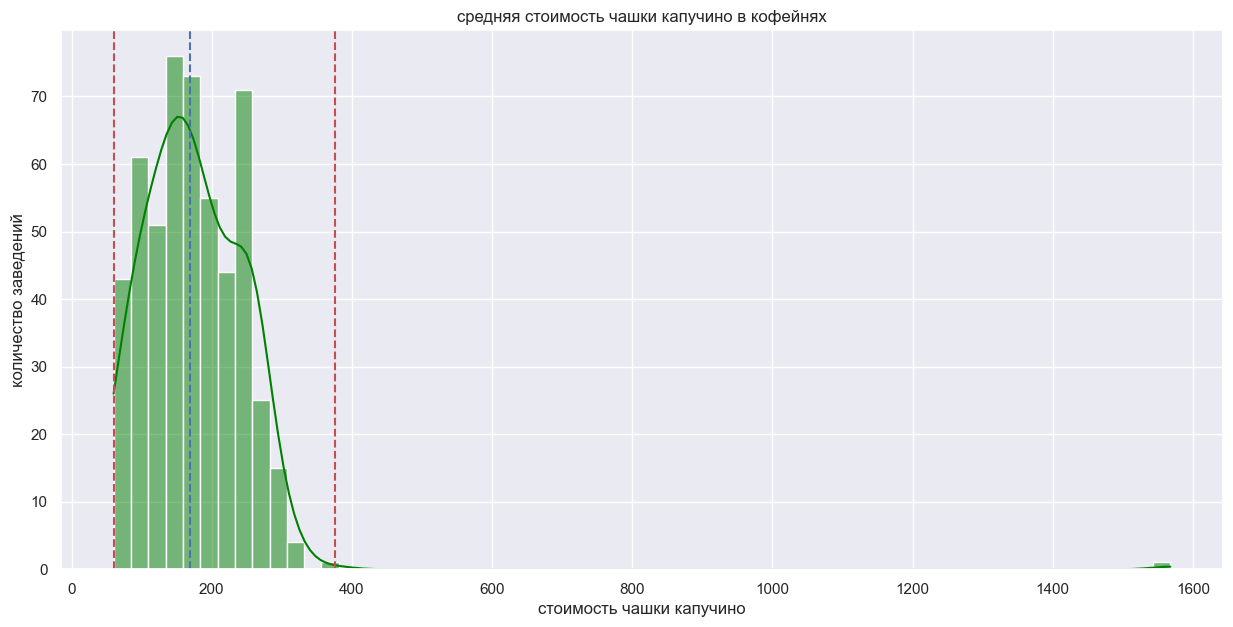

In [80]:
# Добавим подсчёт квартилей
q3, q2, q1 = np.percentile(new_data.loc[(~new_data['middle_coffee_cup'].isna())]['middle_coffee_cup'], [75, 50 ,25])
iqr = q3 - q1
if 1.5*iqr > q1:
    min = new_data['middle_coffee_cup'].min()
else:
    min = q1 - 1.5*iqr 
max = q3 + 1.5*iqr

print('q1: ', q1)
print()
print('q3: ', q3)
print('Минимум: ', min)
print()
print('Медиана: ', q2)
print()
print('Максимум: ', max)

# строим гистограмму по стоимости чашки кофе
plt.figure(figsize=(15, 7))

sns.set()
sns.set_style('darkgrid')

ax = sns.histplot(x='middle_coffee_cup', data=new_data.query('category == "кофейня"'), kde=True, color='green')
plt.axvline(x = min, color = 'r', linestyle = 'dashed')
plt.axvline(x = q2, color = 'b', linestyle = 'dashed')
plt.axvline(x = max, color = 'r', linestyle = 'dashed')
ax.set_title('средняя стоимость чашки капучино в кофейнях')
ax.set_xlabel('стоимость чашки капучино')
ax.set_ylabel('количество заведений')

plt.show()

Здесь имеется отдельный выброс в виде стоимости чашки в почти 1600 рублей (вероятно ошибка), но поскольку случай скорее всего единичный, то просто посмотрим поближе основную часть.  

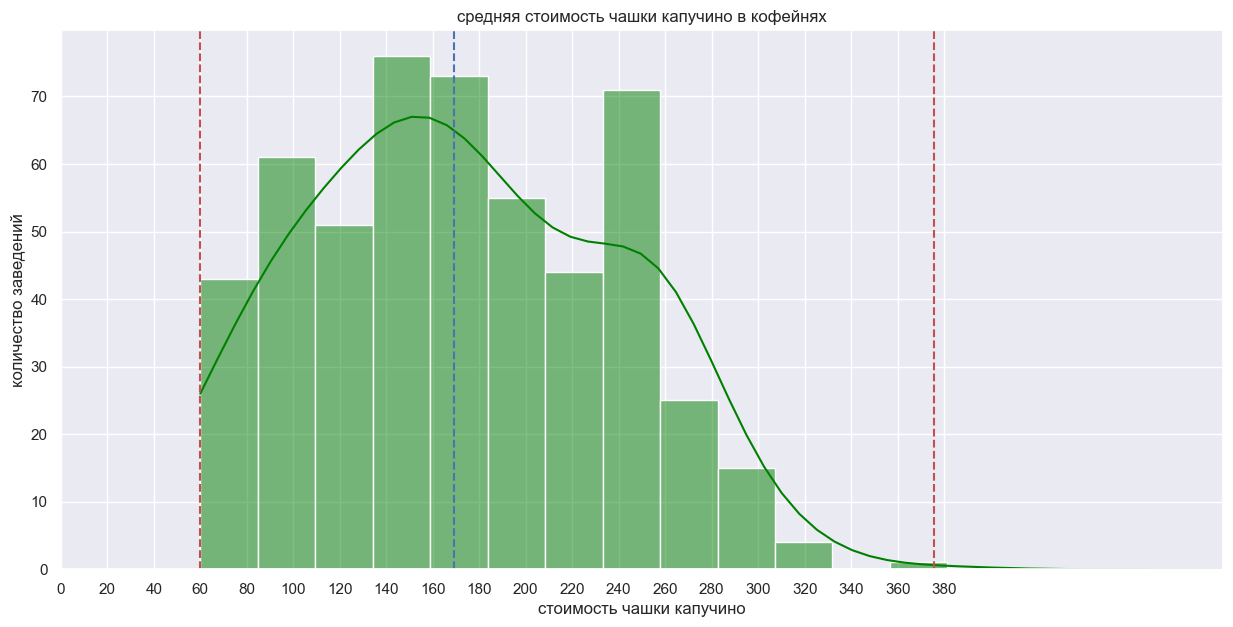

In [81]:
def ticks(mn, mx, step=1):
    line = []
    for num in range(mn, mx, step):
        line.append(num)
    return line

plt.figure(figsize=(15, 7))

sns.set()
sns.set_style('darkgrid')

ax = sns.histplot(x='middle_coffee_cup', data=new_data.query('category == "кофейня"'), kde=True, color='green')
plt.axvline(x = min, color = 'r', linestyle = 'dashed')
plt.axvline(x = q2, color = 'b', linestyle = 'dashed')
plt.axvline(x = max, color = 'r', linestyle = 'dashed')
plt.xlim(0, 500)
plt.xticks(ticks(0, 400, 20))
ax.set_title('средняя стоимость чашки капучино в кофейнях')
ax.set_xlabel('стоимость чашки капучино')
ax.set_ylabel('количество заведений')

plt.show()

Итак, основные цены на чашку капучино располагаются в диапазоне от 60 до 375р. Медианная цена - 169р. При этом очень большое количество заведений продаёт капучино по цене от 135р за чашку до 185р. Есть также достаточно большая группа заведений с ценами от примерно 240р до 260р - либо может сказываться расположение (например, близость к центру), либо какая эксклюзивность самих кофеен. Проверим по карте.

In [82]:
# сгруппируем по районам медианную стоимость чашки капучино
dicstrict_coffee_cup = (
    new_data.query('category == "кофейня"')
    .groupby('district', as_index=False)
    .agg({'middle_coffee_cup':'median'})
    .sort_values(by='middle_coffee_cup', ascending=False)
)
dicstrict_coffee_cup

district  middle_coffee_cup
7      Юго-Западный административный округ              198.0
5       Центральный административный округ              190.0
1          Западный административный округ              189.0
4   Северо-Западный административный округ              165.0
3  Северо-Восточный административный округ              162.5
2          Северный административный округ              159.0
8             Южный административный округ              150.0
6     Юго-Восточный административный округ              147.5
0         Восточный административный округ              135.0

In [83]:
# # ещё раз зададим карту Москвы
# m6 = Map(location=[moscow_lat, moscow_lng], zoom_start=10,  tiles='Open street map')

# # создаём хороплет с помощью конструктора Choropleth и добавляем его на карту
# Choropleth(
#     geo_data=state_geo,
#     data=dicstrict_coffee_cup,
#     columns=['district', 'middle_coffee_cup'],
#     key_on='feature.name',
#     fill_color='Reds',
#     fill_opacity=0.5,
#     legend_name='стоимость чашки капучино в кофейнях по районам',
# ).add_to(m6)

# m6

*скриншот графика*
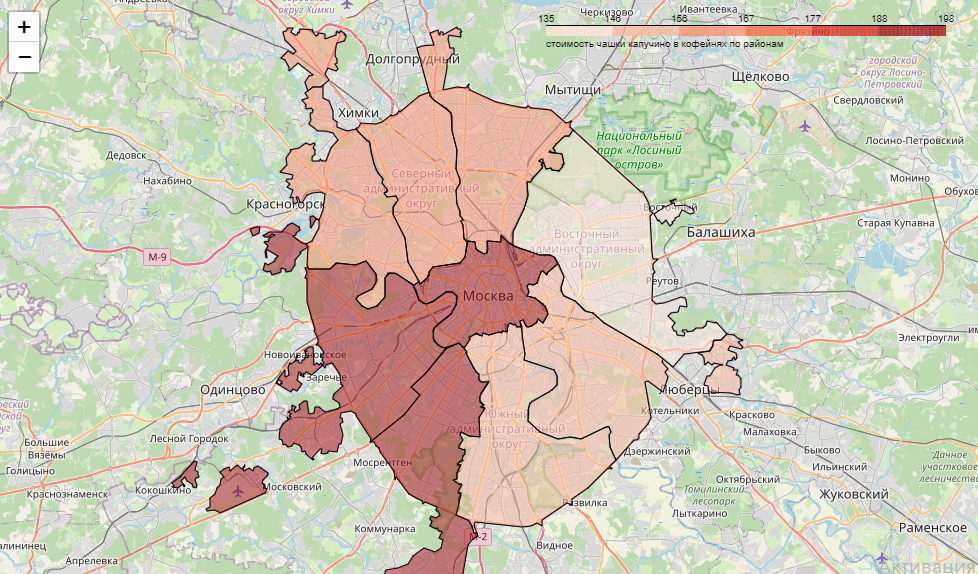

Что можно видеть: самый дорогой капучино в Центральном, Западном и Юго-Западном районах (от 190 до 200 рублей). Ещё в пяти районах около 150-165 рублей. Самый дешёвый в Восточном - около 135р.  
Учитывая полученную информацию по двум графикам цена, на которую стоит ориентироваться - примерно от 135 до 185р (можно ориентироваться по общей медиане - 169р), чтобы можно было бы охватить максимум потенциальных покупателей (если рассматривать исключительно центр - можно ориентироваться на цены близкие к верхней границе) 

**Итого по кофейням:**
- лидером по количеству кофеен является Центральный административный район (426 кофеен), что может быть связано с различными местами притяжения как жителей Москвы, так и для туристов (исторические места, крупные парки, театры, музеи, ВУЗы и деловые центры и т.д.).  На втором месте - Северный административный округ - 192 заведения. Меньше всего кофеен в Восточном, Юго-Западном, Юго-Восточном и Северо-Западном административных округах
- всего 4,36% кофеен (61 заведение) работает круглосуточно
- Самый высокий рейтинг среди кофеен в Центральном и Северо-Западном районах - выше 4.32 балла. У Северного, Юго-Западного и Восточных районов - от 4.27 до 4.30. Южный и Юго-Восточный районы - около 4.22. Самый низкий рейтинг у Северо-Восточного и Западного округов - от 4.19 до примерно 4.21
- основные цены на чашку капучино располагаются в диапазоне от 60 до 375р. Медианная цена - 169р. При этом очень большое количество заведений продаёт капучино по цене от 135р за чашку до 185р. Есть также достаточно большая группа заведений с ценами от примерно 240р до 260р. самый дорогой капучино в Центральном, Западном и Юго-Западном районах (от 190 до 200 рублей). Ещё в пяти районах около 150-165 рублей. Самый дешёвый в Восточном - около 135р
- итого, цена, которую стоит брать в расчёт в первую очередь - примерно от 135 до 185р (лучше ориентироваться по общей медиане - 169р). Если в охват идёт только центральный район, то можно ориентироваться на верхние границы.

## Выводы:
1) по ознакомлению с данными и предобработке:
- получен датасет с информацией о местах общественного питания в Москве, который содержит данные о названии заведения, его категории, о его местоположении (адрес, район, координаты), часы работы, уровень цен, категория (диапазон) среднего чека, оценка среднего чека, оценка чашки капучино, принадлежность к сети.   
- в исходном датасете имеется 8406 записей о заведениях общепита в Москве.
- в изначальном варианте имелось 5614 уникальных названий заведений. Поскольку среди названий могли быть неявные дубликаты, когда одно и то же название было записано разными способами, была проведена дополнительная обработка таких наименований. Результат - дополнительно отсеяно 134 повторяющихся наименования, уникальных названий осталось 5480 (из них 742 сетевых заведения).
- проведена проверка на возможные дубликаты по наименованию и адресу – 4 лишние строки удалены
- перепроверены категории заведений, которые входят в различные сети. В случаях, где упоминались несколько категорий, но на одну категорию приходилось более 65% упоминаний. Редкие категории исправлены на основную в рамках сети. Исправления затронули 768 записей (в 110 сетях)
- все указанные в датасете адреса относятся к Москве 
- в столбце с административными районами не обнаружены дубликаты
- в столбце с временем работы заведений обнаружено 535 пропусков (6,4% от всего датасета – не очень критично). Пропуски заменены на «неизвестно»
- при проверке столбцов с координатами было выявлено 64 заведения, которые располагаются по одному и тому же адресу с другими заведениями. При этом был обнаружен один дубликат, который был успешно удалён.
- при обработке столбца с сетями было обнаружено, что у части заведений, чьи названия в большинстве случаев отмечены сетями, в отдельных случаях отметка «сеть» не была указана (таких заведений было 56). Обработаны были только те наименования, у которых доля заведений с отметкой сеть была больше 50%. Это затронуло 41 заведение.
- в столбце с категорией цен обнаружено много пропусков (5086). У сетевых 2095 пропусков. Часть пропусков в рамках сети заполнено по основной категории в рамках сети - обработано 240 пропусков.
- много пропусков в столбце со средней стоимостью заказа. Обработать возможности не было.
- в столбце с оценкой среднего чека 5252 пропуска. Часть пропусков удалось отработать по соответствующим значениям столбца `avg_bill` (обработано 132 пропуска). В столбце с оценкой чашки кофе пропусков 7866. Аналогичным способом их обработать не удалось
- у столбца с количество посадочных мест 3609 пропусков – их обработать невозможно. Нормальные значения с числом посадочных мест располагаются в диапазоне от 0 до 290.

2) В рамках общего анализа данных:
- Датасете представлены 8 различных вариантов категорий заведений (кафе, рестораны, кофейни, пиццерии, бар/паб, заведения быстрого питания, булочные и столовые). В топ-3 по числу представленных заведений входят «кафе» (составляют 28,7% от всего количества заведений), рестораны (24,1%) и кофейни (16,7%). Слабее всего представлены булочные (3,23%) и столовые (3,71%).
- По количеству посадочных мест лидирует категория «ресторан» (в среднем около 80 мест), второе и третье места занимают бары и кофейни (около 75 и 70 мест в среднем) меньше всего у пиццерий (около 50) и у булочных (в районе 47).
- Почти 39% заведений датасета являются представителями каких-то сетей. Соответственно на несетевые заведения приходится 61%. При этом среди сетевых заведений в большей степени преобладают кафе (25,6%), рестораны (22,3%) и кофейни (21,9%). Самая малочисленная сетевая категория – столовые (2,65%). Наибольший процент сетевых заведений можно наблюдать у категории "булочная" (63.47%). Также довольно часто в рамках сетей развиваются пиццерии (52.53%) и кофейни (50.89%); реже всего сетями являются столовые (27.56%) и бары (22.02%)
- Самыми популярными сетями (с точки зрения количества заведений) являются кофейня «Шоколадница» (почти 120 заведений), пиццерии «Доминос пицца» и «додо пицца», «яндекс лавка», достаточно распространённые кофейни «one price coffee» и «cofix». 40% заведений из топ-15 сетевых – это кофейни. Также достаточно большие доли имеют рестораны (22,3%), пиццерии (18,6%) и кафе (13%).
- При анализе заведений по районам можно сделать вывод, что подавляющее число заведений находится в центральном районе (2242 заведения). В этом районе основными категориями являются рестораны (670), кафе (466), кофейни (426) и бары (362). При этом у остальных районов количество заведений примерно одинаковое (от 700 до 900 заведений). Самый малочисленный район в плане количества заведений – Северо-Западный административный округ – всего 409 заведений. Почти во всех остаётся примерно одинаковый топ-3 категорий заведений - кафе, рестораны и кофейни. 
- Явных различий в среднем рейтинге у категорий заведений не наблюдается – средний рейтинг укладывается в диапазон от 4.2 до 4.4 баллов. Самый высокий средний балл у баров (4.4), самые низкие оценки – у кафе (4.2) и у заведений быстрого питания (4.2). У остальных средний рейтинг 4.3.
- заведения с наиболее высоким рейтингом (в среднем около 4.4 баллов) располагаются в большинстве своём в центральном районе. Самые низкие рейтинги у заведений Северо-Восточного и Юго-восточного административных округов (около 4.2). У остальных районов средний рейтинг примерно одинаковый – в районе 4.3
- Больше всего заведений находится на проспекте Мира – 183 заведения. Также достаточно большое количество заведений находится Профсоюзной улице, проспекте Вернадского и Ленинском проспекте (в каждом случае имеется более 100 заведений). В большинстве случаев в разрезе по категориям на улицах тройку лидеров удерживают кафе, рестораны и кофейни.
- имеется 458 улиц, на которых располагается только одно заведение. В подавляющем большинстве случае это заведения из категории «кафе» (160 заведений), «рестораны» (92шт) и «кофейни» (83шт). Меньше всего таких заведений представлены категориями «булочные» и «пиццерии». При этом на таких улицах средний рейтинг у заведений как правило чуть выше, чем в целом по городу. Самый высокий рейтинг у баров – 4,5, самый низкий у кафе – 4,2.
- По размеру среднего чека в разрезе по районам лидируют центральный округ и западный. Восточные районы в среднем дешевле, чем западные.

3) отдельно по кофейням:
- лидером по количеству кофеен является Центральный административный район (426 кофеен). На втором месте - Северный административный округ - 192 заведения. Меньше всего кофеен в Восточном, Юго-Западном, Юго-Восточном и Северо-Западном административных округах. 
- всего 4,36% кофеен (61 заведение) работает круглосуточно
- Самый высокий рейтинг среди кофеен в Центральном и Северо-Западном районах - выше 4.32 балла. У Северного, Юго-Западного и Восточных районов - от 4.27 до 4.30. Южный и Юго-Восточный районы - около 4.22. Самый низкий рейтинг у Северо-Восточного и Западного округов - от 4.19 до примерно 4.21
- цена, которую стоит брать в расчёт в первую очередь - примерно от 135 до 185р (лучше в верхней границе ориентироваться по общей медиане - 169р). Если в охват идёт только центральный район, то можно опираться на верхние границы.

Итого:
- если говорить о наиболее популярных форматах заведений, то стоит обращать внимание на кафе, рестораны и кофейни.
- наиболее привлекательными районами для размещения заведения являются Центральный административный округ  (если берём количество подобных заведений как маркер популярности формата, но нужно помнить об очень серьёзной конкуренции)
- с точки зрения количества посадочных мест, то для популярного заведения - это около 70 - 75
- если в целях стоит построить сетевое заведение, то предпочтительным форматом является "кофейня". При этом кофейня являются сетевым заведением примерно 50% случаев
- если говорить исключительно о кофейнях, то наиболее благоприятные районы для них с точки зрения популярности - также Центральный и Северный (опять, если не бояться конкуренции)
- нет никакого смысла делать кофейни круглосуточными.
- на рейтинги ориентироваться сложно, но опять же, если отталкиваться от рейтинга как маркера популярности формата, то наиболее благоприятными районами являются Центральный и Северо-Западный.
- наиболее ожидаемая цена чашки капучино - в диапазоне от 135 до 169р. 

Презентация:  <https://disk.yandex.ru/i/c8AJdWj7BifIPg>